In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model

from sklearn.metrics import mean_squared_error

#knn imputer
from sklearn.neighbors import KNeighborsRegressor

#feature filtering/processing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#outliers
from sklearn.ensemble import IsolationForest

#plot tree
from sklearn.tree import plot_tree

#sns configuration
sns.set(style="ticks", color_codes=True)

#investigate data
pd.set_option('display.max_columns', None)

#dictionary
import collections

#display dataframe
from IPython.display import display

#hyperparameters tuning
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.regression.linear_model as smrlm
import statsmodels.api as sm
from scipy.stats import randint

import math

from graph_utils import *
from utils import *

# Knowledge

1. Fetus = which fetus is it (first fetus, second fetus)

In [2]:
#read csv
df_1112 = pd.read_excel('data/FGR_STUDY 20112012.xls', header=2)
df_1213 = pd.read_excel('data/FGR_STUDY 20122013.xls', header=2)
df_1314 = pd.read_excel('data/FGR_STUDY 20132014.xls', header=2)
df_1415 = pd.read_excel('data/FGR_STUDY 20142015.xls', header=2)
df_1516 = pd.read_excel('data/FGR_STUDY 20152016.xls', header=2)
df_1617 = pd.read_excel('data/FGR_STUDY 20162017.xls', header=2)
df_1718 = pd.read_excel('data/FGR_STUDY 20172018.xls', header=2)
df_1819 = pd.read_excel('data/FGR_STUDY 20182019.xls', header=2)
df_1920 = pd.read_excel('data/FGR_STUDY 20192020.xls', header=2)
df_2021 = pd.read_excel('data/FGR_STUDY 20202021.xls', header=2)

In [3]:
df_2021 = df_2021.rename(columns={'GA (WK)': ' (2)', 'GA (DAYS)': ' (3)'})

In [4]:
frames = [df_1112, df_1213, df_1314, df_1415, df_1516, df_1617, df_1718, df_1819, df_1920, df_2021]
df_master = pd.concat(frames)

In [5]:
#(2) is Gweek, (3) is Gday (I guess)
df_master['GA(day)'] = df_master[' (2)'] * 7 + df_master[' (3)']
df_master['GA(week)'] = df_master['GA(day)'] // 7

In [6]:
#drop some unecessary columns
df_master = df_master.drop([' (2)', ' (3)'], axis=1)

In [7]:
df_master = df_master[~df_master['EFW (clinical)'].isnull()]

In [8]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96510 entries, 0 to 16784
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       96510 non-null  int64         
 1   Case number               96510 non-null  int64         
 2   Exam                      96510 non-null  int64         
 3   Fetus                     96510 non-null  float64       
 4   Hospital no.              96510 non-null  object        
 5   Ethnic_group              265 non-null    object        
 6   BPD                       96348 non-null  float64       
 7   HC                        96468 non-null  float64       
 8   TCD                       25859 non-null  float64       
 9   AC                        96499 non-null  float64       
 10  CM                        21435 non-null  float64       
 11  FL                        96492 non-null  float64       
 12  Humerus           

## Personal Preprocessing

1. Removing features with <1000 non-null :
    - 4   Ethnic_group              265 non-null    object  
    - 26  A-wave                    359 non-null    object        
    - 27  Ductus Venosus PI         135 non-null    float64       
    - 28  TAV                       14 non-null     float64       
    - 29  Uterine artery PI  left   107 non-null    float64       
    - 30  Uterine artery PI  right  116 non-null    float64       
    - 31  RI left                   97 non-null     float64       
    - 32  RI right                  107 non-null    float64       
    - 33  Notch                     87 non-null     object        
    - 34  Funnelling                384 non-null    object        
    - 35  Cervix length             426 non-null    float64  
 
2. Correcting dtypes of:
    - Fetus                     96510 non-null  float64 >> int32
    - Presentation              95572 non-null  object >> category  
    - Placenta site             94756 non-null  object >> category  
    - Amniotic fluid            94511 non-null  object >> category
    - Cord                      34048 non-null  object >> category    
    
3. Remove fetus 2 (we only focus on singleton pregnancies)

In [9]:
#dropping mostly missing features
# df_master = df_master.drop(['Ethnic_group', 'A-wave', 'Ductus Venosus PI', 'TAV',
#                             'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
#                             'RI right', 'Notch', 'Funnelling', 'Cervix length',], axis=1)

#correcting dtypes
df_master['Fetus'] = df_master['Fetus'].astype('int32')
df_master['Presentation'] = df_master['Presentation'].astype('category')
df_master['Placenta site'] = df_master['Placenta site'].astype('category')
df_master['Amniotic fluid'] = df_master['Amniotic fluid'].astype('category')
df_master['Cord'] = df_master['Cord'].astype('category')

#removing fetus>1 mothers
patient_remove = list(df_master[df_master['Fetus'] > 1]['Hospital no.'].unique())
df_master = df_master[~df_master['Hospital no.'].isin(patient_remove)]

In [10]:
df_master.shape

(89397, 45)

# Split into 3 seperate dataframe

Retrieved from 374 patients in previous df: 

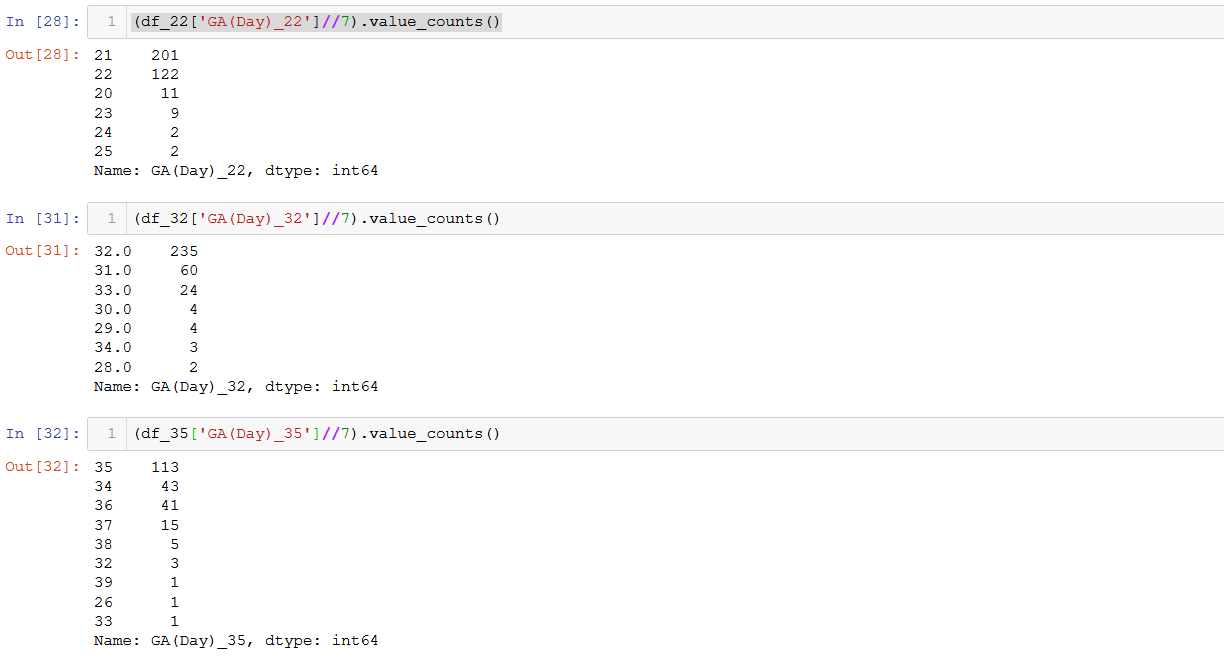

Basically:
1. Wk22 = <28 || Wk32 = 28 - 34 || Wk35 = >34
- get common hospital no. from each df, then filter.
- A patient not necessary has only 1 scan in each wk. - my idea here is that it's okay to more scan, because it will be used to forecast the same value in the other wk anyways.
    - So I think that the GA(week) of the forecasted week need to be an input of the model.
    - by using merge:
        - Let say patient A has 2 row of records in both wk22 and wk32. This will create 4 rows (each row in wk22 associated with each row in wk32)


In [11]:
def get_cat(week):
    '''
    Wk22 = <28 Wk32 = 28 - 34 Wk35 = >34
    '''
    
    if week < 28:
        return 'wk22'
    elif week > 34:
        return 'wk35'
    else:
        return 'wk32'

df_master['df_cat'] = df_master['GA(week)'].apply(lambda x: get_cat(x))

In [12]:
df_master

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
0,8,1,1,1,25208098,Malay,83.7,285.0,NaN,292.3,NaN,60.0,55.5,1984.0,21.4,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-10,NaN,NaN,NaN,NaN,234.0,33.0,wk32
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22
6,17,1,1,1,04841360,NaN,82.9,309.2,NaN,290.8,NaN,64.4,NaN,2164.0,7.4,NaN,cephalic,posterior high,10.5,normal,NaN,0.86,0.59,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,249.0,35.0,wk35
7,19,1,1,1,31159261,NaN,88.8,319.4,NaN,298.4,NaN,61.4,NaN,2249.0,15.3,NaN,cephalic,anterior high,8.8,normal,NaN,0.66,0.49,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,246.0,35.0,wk35
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,7.9,37.1,NaN,452.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16773,43836,1,1,1,34500839,NaN,52.3,195.2,24.9,178.9,4.7,37.2,NaN,490.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,156.0,22.0,wk22
16778,43840,1,2,1,36157691,NaN,71.0,255.6,NaN,236.6,NaN,52.4,NaN,1154.0,6.3,NaN,cephalic,posterior high,10.3,normal,NaN,NaN,NaN,positive,NaN,NaN,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-18,1.14,0.69,1.46,0.75,210.0,30.0,wk32
16779,43840,1,1,1,36157691,NaN,68.5,247.8,NaN,217.5,NaN,46.0,NaN,882.0,7.4,NaN,cephalic,posterior high,10.0,normal,NaN,NaN,NaN,positive,NaN,NaN,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,1.13,0.67,1.60,0.85,197.0,28.0,wk32
16782,43843,1,1,1,35146320,NaN,62.8,229.1,28.8,204.1,7.8,46.2,42.1,776.0,26.7,148.0,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-06,NaN,NaN,NaN,NaN,181.0,25.0,wk22


In [13]:
df_new = df_master.groupby('df_cat')  
df_22 = df_new.get_group('wk22')
df_32 = df_new.get_group('wk32')
df_35 = df_new.get_group('wk35')

In [14]:
df_35.shape

(31658, 46)

In [15]:
no_22 = set(df_22['Hospital no.'].unique())
no_32 = set(df_32['Hospital no.'].unique())
no_35 = set(df_35['Hospital no.'].unique())

In [16]:
common_no = no_22.intersection(no_32).intersection(no_35)

In [17]:
df_32[df_32['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13122,19636,1,4,1,01036335,NaN,70.1,266.1,NaN,245.4,NaN,52.2,NaN,1228.0,40.5,NaN,cephalic,anterior high,12.3,normal,NaN,0.93,0.62,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-29,NaN,NaN,NaN,NaN,202.0,28.0,wk32
13120,19636,1,5,1,01036335,NaN,76.5,287.6,NaN,282.1,NaN,61.3,NaN,1864.0,46.4,NaN,cephalic,anterior high,12.4,normal,NaN,0.82,0.57,positive,1.76,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,33.0,Hadlock (BPD-HC-AC-FL),2016-04-19,NaN,NaN,NaN,NaN,223.0,31.0,wk32
2697,11013,1,2,1,01059564,NaN,73.6,264.7,NaN,246.3,NaN,50.7,NaN,1214.0,48.1,NaN,Variable,posterior high,28.0,polyhydramnios,NaN,1.34,0.75,NaN,2.15,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-07-08,NaN,NaN,NaN,NaN,200.0,28.0,wk32
2696,11013,1,3,1,01059564,NaN,84.7,304.0,NaN,295.3,NaN,61.8,NaN,2136.0,62.0,NaN,cephalic,posterior high,29.4,polyhydramnios,NaN,1.05,0.68,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-08-05,NaN,NaN,NaN,NaN,228.0,32.0,wk32
3298,1630,1,2,1,01067818,NaN,81.6,301.4,NaN,282.9,NaN,66.6,NaN,2110.0,27.6,NaN,cephalic,Placenta praevia,14.7,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-01-29,NaN,NaN,NaN,NaN,236.0,33.0,wk32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,43097,1,2,1,36060333,NaN,87.8,312.1,NaN,315.3,NaN,65.6,NaN,2559.0,86.2,NaN,cephalic,anterior high,16.0,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,233.0,33.0,wk32
14641,43461,1,2,1,36066718,NaN,71.2,257.3,NaN,238.2,NaN,53.4,NaN,1191.0,24.6,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,positive,NaN,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-07,0.91,0.62,1.75,0.79,204.0,29.0,wk32
14642,43461,1,3,1,36066718,NaN,76.6,276.5,NaN,248.3,NaN,56.7,53.1,1408.0,14.3,NaN,cephalic,anterior high,10.6,normal,3 vessels,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-19,0.99,0.63,NaN,NaN,216.0,30.0,wk32
14431,43391,1,2,1,36067895,NaN,84.5,313.4,NaN,299.2,NaN,56.0,53.6,2045.0,21.6,NaN,cephalic,posterior high,7.1,reduced,NaN,NaN,NaN,positive,NaN,NaN,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-26,0.65,0.49,1.52,NaN,236.0,33.0,wk32


In [18]:
df_22[df_22['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13123,19636,1,2,1,01036335,NaN,46.6,173.5,20.5,161.8,2.4,34.8,NaN,390.0,NaN,NaN,transverse,anterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74,NaN,0.5,no notch,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-02-02,NaN,NaN,NaN,NaN,146.0,20.0,wk22
13118,19636,1,3,1,01036335,NaN,59.5,230.4,NaN,198.7,NaN,44.7,NaN,719.0,29.6,NaN,transverse,anterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-01,NaN,NaN,NaN,NaN,174.0,24.0,wk22
2698,11013,1,1,1,01059564,NaN,50.7,187.4,21.4,151.4,4.3,36.9,35.6,393.0,NaN,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-05-21,NaN,NaN,NaN,NaN,152.0,21.0,wk22
2000,1630,1,1,1,01067818,NaN,63.3,250.8,NaN,214.5,NaN,48.3,NaN,897.0,36.2,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-12-11,NaN,NaN,NaN,NaN,187.0,26.0,wk22
9225,12763,1,1,1,01080296,NaN,51.4,190.0,NaN,170.0,NaN,38.4,NaN,469.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-09-17,NaN,NaN,NaN,NaN,151.0,21.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16223,43200,1,1,1,36054730,NaN,51.3,192.4,23.7,184.0,5.8,39.7,36.2,536.0,NaN,150.0,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-16,NaN,NaN,NaN,NaN,163.0,23.0,wk22
16133,43097,1,1,1,36060333,NaN,72.7,272.6,NaN,249.1,NaN,51.0,47.4,1252.0,87.5,NaN,transverse,anterior high,24.0,increased,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-03,NaN,NaN,NaN,NaN,193.0,27.0,wk22
14643,43461,1,1,1,36066718,NaN,64.2,235.3,31.1,215.3,4.3,50.1,NaN,918.0,37.7,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,26.0,Hadlock (BPD-HC-AC-FL),2021-03-22,NaN,NaN,NaN,NaN,188.0,26.0,wk22
14433,43391,1,1,1,36067895,NaN,69.1,255.4,34.5,247.0,NaN,49.6,NaN,1160.0,68.0,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,194.0,27.0,wk22


# Visualization

In [22]:
def visualize_val_edit(value_cols, df_22, df_32, df_35, hue=None):
    section = [math.ceil(i) for i in np.linspace(start = 0, stop = len(value_cols), num = 5)]
    for i in range(len(section)-1):
        cols = value_cols[section[i]: section[i+1]]
        fig, ax = plt.subplots(len(cols), 3, figsize=(35,35))
        for index, col in enumerate(cols):
            
            xlim = [min(min(df_22[~df_22[col].isnull()][col]), min(df_32[~df_32[col].isnull()][col]), min(df_35[~df_35[col].isnull()][col])), 
                    max(max(df_22[~df_22[col].isnull()][col]), max(df_32[~df_32[col].isnull()][col]), max(df_35[~df_35[col].isnull()][col]))]
            
            xlim[0] -= (xlim[0]//10)
            xlim[1] += (xlim[1]//10)
            
            sns.set_palette('flare')
            a = sns.boxplot(x=col, data=df_22, ax=ax[index, 0], hue=hue)
            a.set_xlabel('', fontsize = 30.0) # X label
            a.set_ylabel(col, fontsize=30.0)
            a.tick_params(labelsize=30)
            a.axis(xmin=xlim[0],xmax=xlim[1])

            sns.set_palette("pastel")
            b = sns.boxplot(x=col, data=df_32, ax=ax[index, 1], hue=hue)
#             b.set_xlabel('', fontsize = 30.0) # X label
#             b.set_ylabel('', fontsize=30.0)
            b.tick_params(labelsize=30)
            if xlim[0] != 'nan':
                b.axis(xmin=xlim[0],xmax=xlim[1])

            sns.set_palette("muted")
            c = sns.boxplot(x=col, data=df_35, ax=ax[index, 2], hue=hue)
#             c.set_xlabel('', fontsize = 30.0) # X label
#             c.set_ylabel('', fontsize=30.0)
            c.tick_params(labelsize=30)
            if xlim[0] != 'nan':
                c.axis(xmin=xlim[0],xmax=xlim[1])

    fig.tight_layout()
    plt.show()
    
def visualize_cat(cols, df_22, df_32, df_35, hue=None):
    '''visulizing categorical data'''
    fig, ax = plt.subplots(len(cols) , 3, figsize=(35,25))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_22, ax=ax[index, 0], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)
        
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_32, ax=ax[index, 1], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel('', fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)
        
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_35, ax=ax[index, 2], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel('', fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

sns.set_palette('flare')
value_cols = df_master.select_dtypes(include=['float64']).columns
cat_cols = df_master.select_dtypes(include=['category']).columns

SyntaxError: invalid syntax (Temp/ipykernel_13004/555231244.py, line 44)

In [20]:
df_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26603 entries, 5 to 16782
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       26603 non-null  int64         
 1   Case number               26603 non-null  int64         
 2   Exam                      26603 non-null  int64         
 3   Fetus                     26603 non-null  int32         
 4   Hospital no.              26603 non-null  object        
 5   Ethnic_group              77 non-null     object        
 6   BPD                       26585 non-null  float64       
 7   HC                        26588 non-null  float64       
 8   TCD                       21012 non-null  float64       
 9   AC                        26602 non-null  float64       
 10  CM                        19623 non-null  float64       
 11  FL                        26601 non-null  float64       
 12  Humerus           

In [21]:
df_22.head()

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,7.9,37.1,NaN,452.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
18,30,1,1,1,29779790,NaN,50.7,191.7,23.3,168.6,4.2,37.9,NaN,459.0,NaN,NaN,Extended breech,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
22,34,1,1,1,27591077,NaN,46.8,175.1,22.2,151.6,5.1,32.4,NaN,340.0,NaN,NaN,breech,fundal,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,145.0,20.0,wk22
27,38,1,1,1,12350378,NaN,51.2,190.7,22.1,163.8,6.0,34.8,NaN,410.0,NaN,NaN,Extended breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,142.0,20.0,wk22


In [83]:
def visualize_val_edit(value_cols, df_22, df_32, df_35):
    
    df_22['df'] = 'df_22'
    df_32['df'] = 'df_32'
    df_35['df'] = 'df_35'
    
    df_master = pd.concat([df_22, df_32, df_35])
    
    fig, ax = plt.subplots(len(value_cols), figsize=(15,35))
    fig.subplots_adjust(top=2)
    for index, col in enumerate(value_cols):
        sns.set_palette('flare')
        a = sns.boxplot(x=col, y='df', data=df_master, ax=ax[index])
        a.set_xlabel('', fontsize = 20.0) # X label
        a.set_ylabel(col, fontsize=20.0)
        a.tick_params(labelsize=20.0)

    fig.tight_layout()
    plt.show()

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

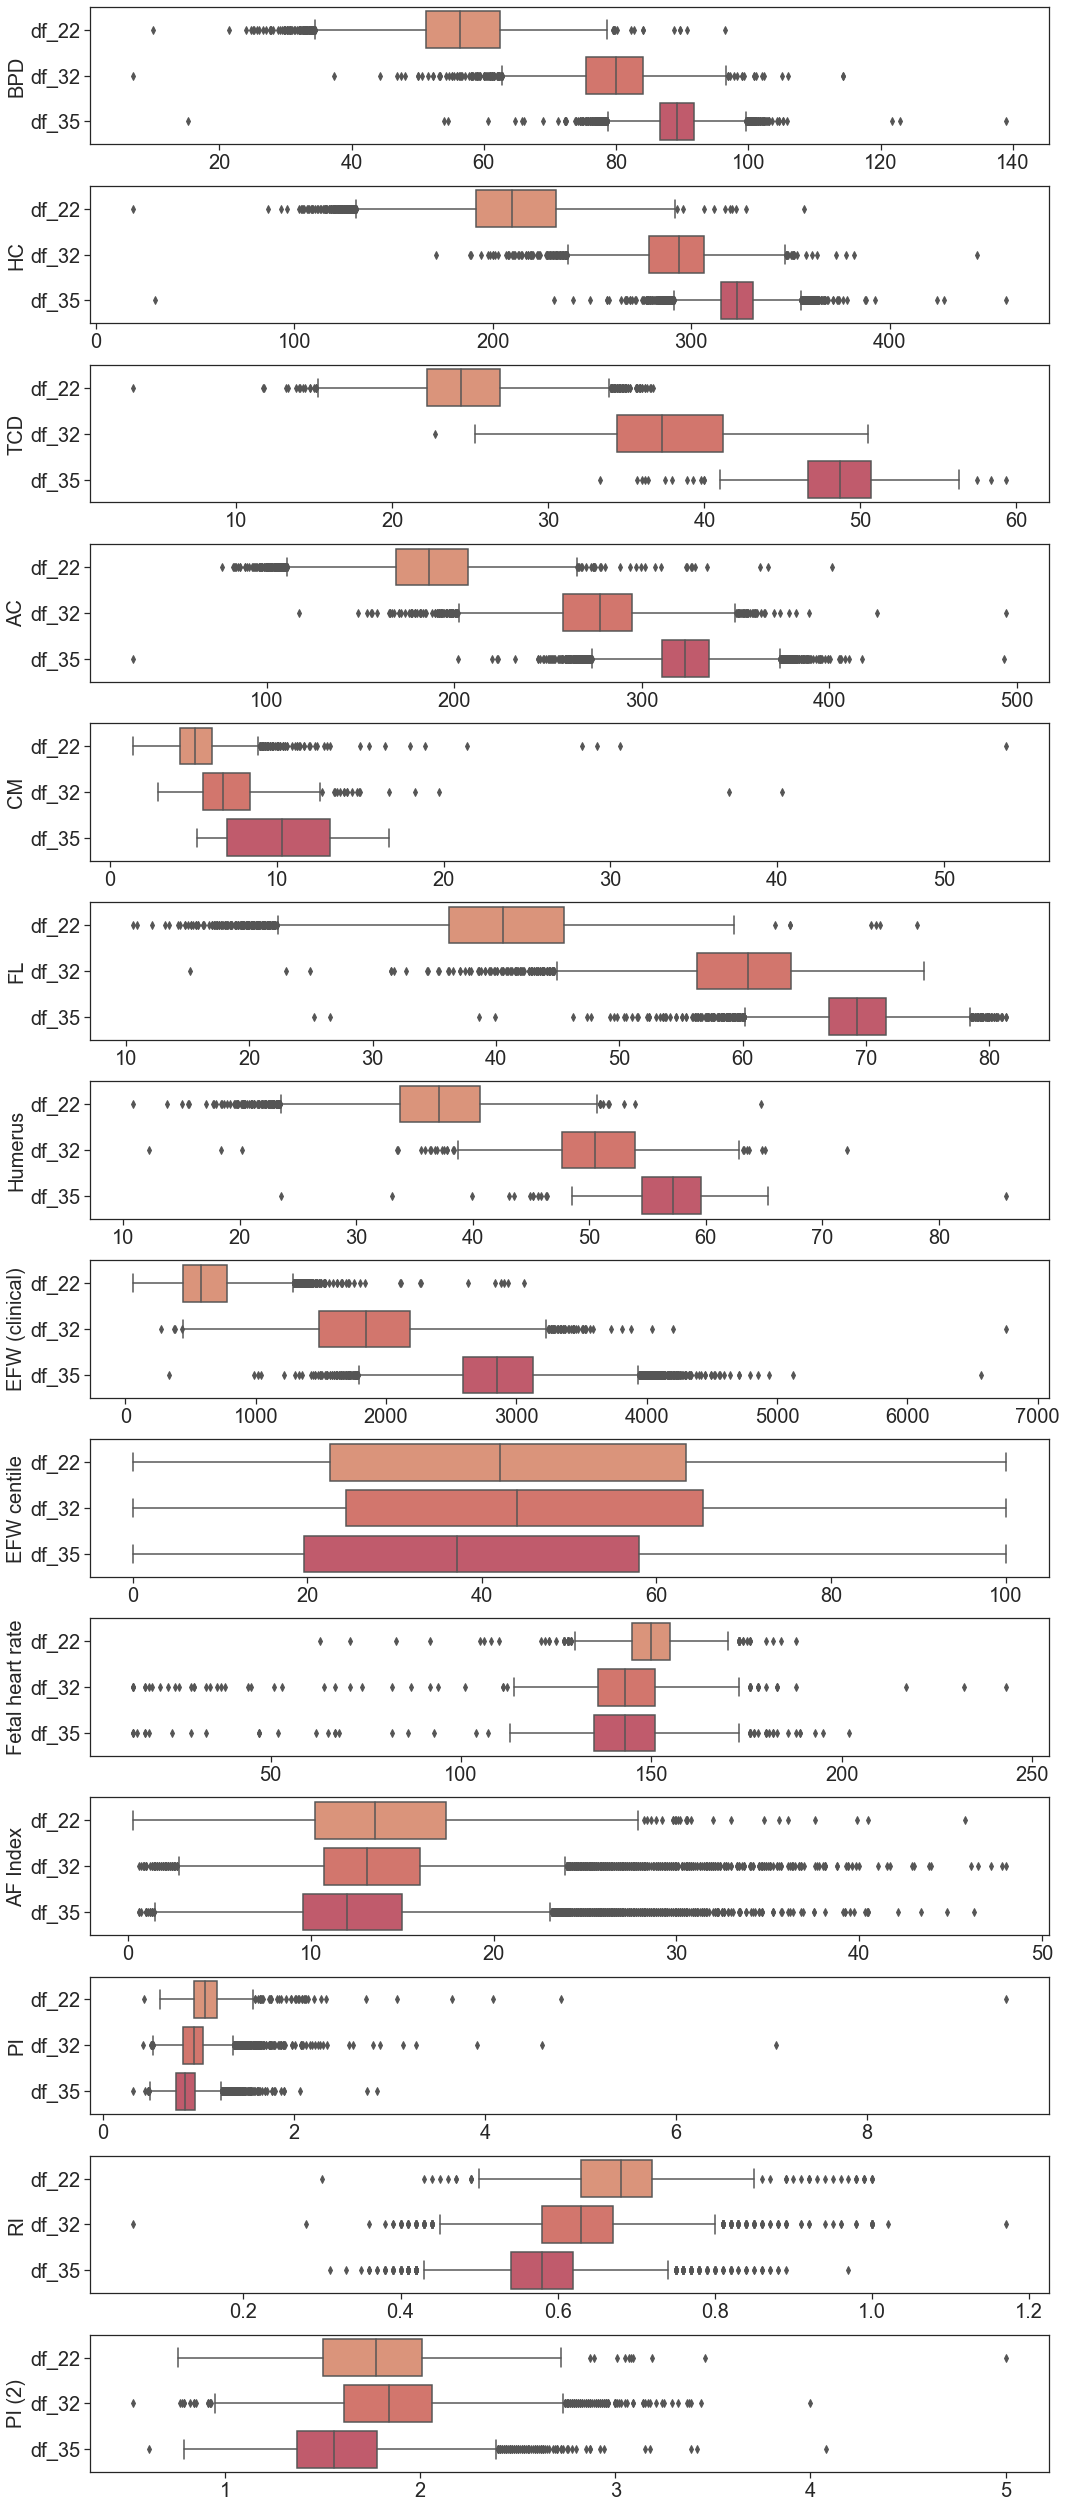

In [54]:
#wk22 --- wk32 --- wk35
visualize_val_edit(value_cols[:len(value_cols)//2], df_22, df_32, df_35)

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/1040397474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

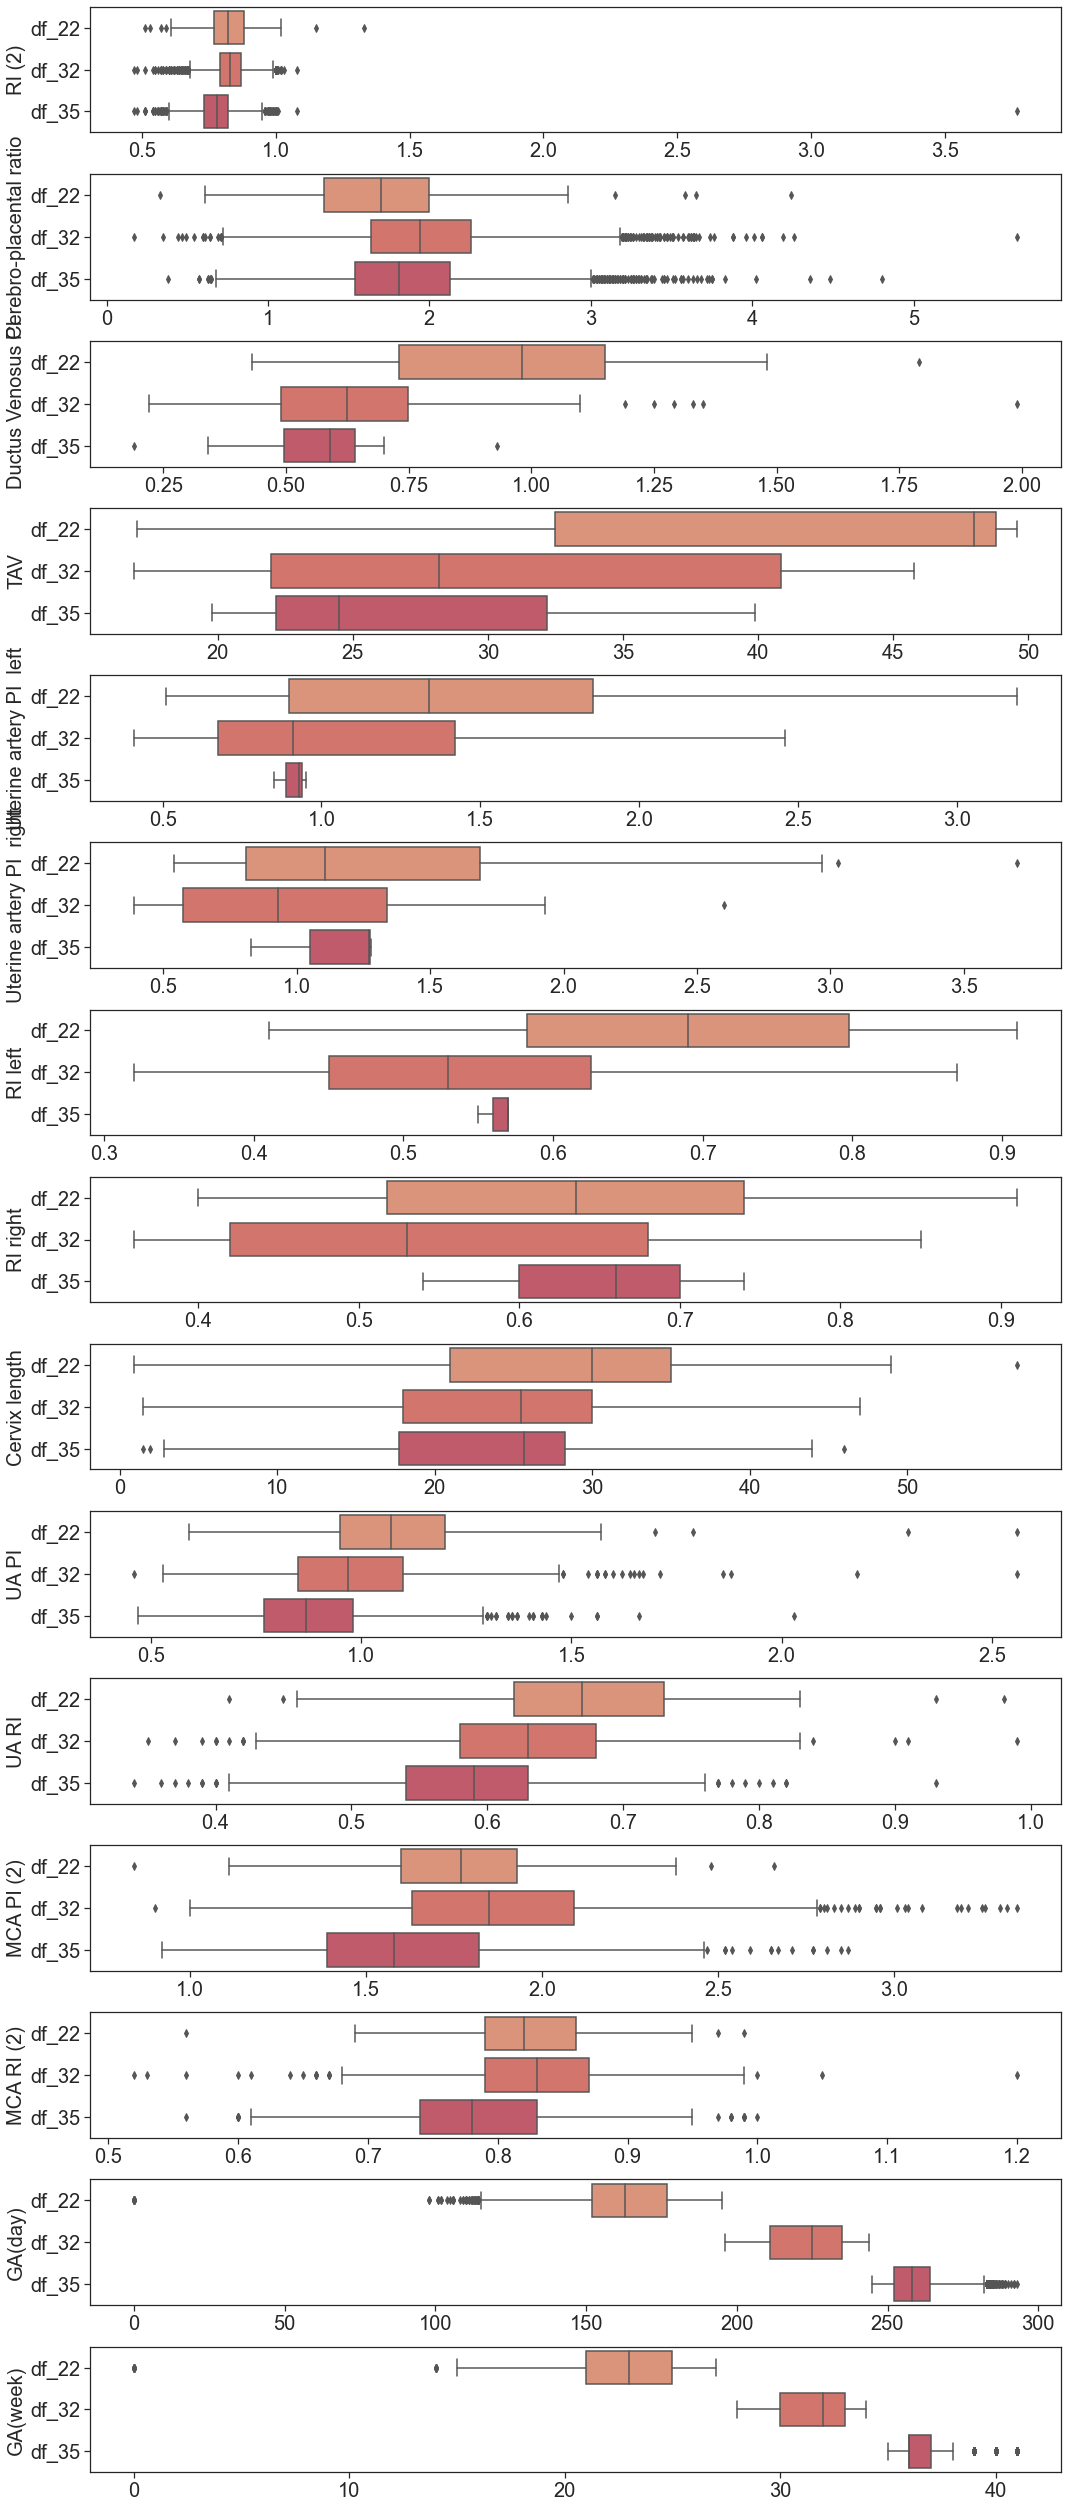

In [55]:
visualize_val_edit(value_cols[len(value_cols)//2:], df_22, df_32, df_35)

In [67]:
def visualize_cat(cols, df_22, df_32, df_35):
    '''visulizing categorical data'''
    
    df_22['df'] = 'df_22'
    df_32['df'] = 'df_32'
    df_35['df'] = 'df_35'
    
    df_master = pd.concat([df_22, df_32, df_35])
    
    fig, ax = plt.subplots(len(cols), figsize=(15,35))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_master, ax=ax[index], hue='df')
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

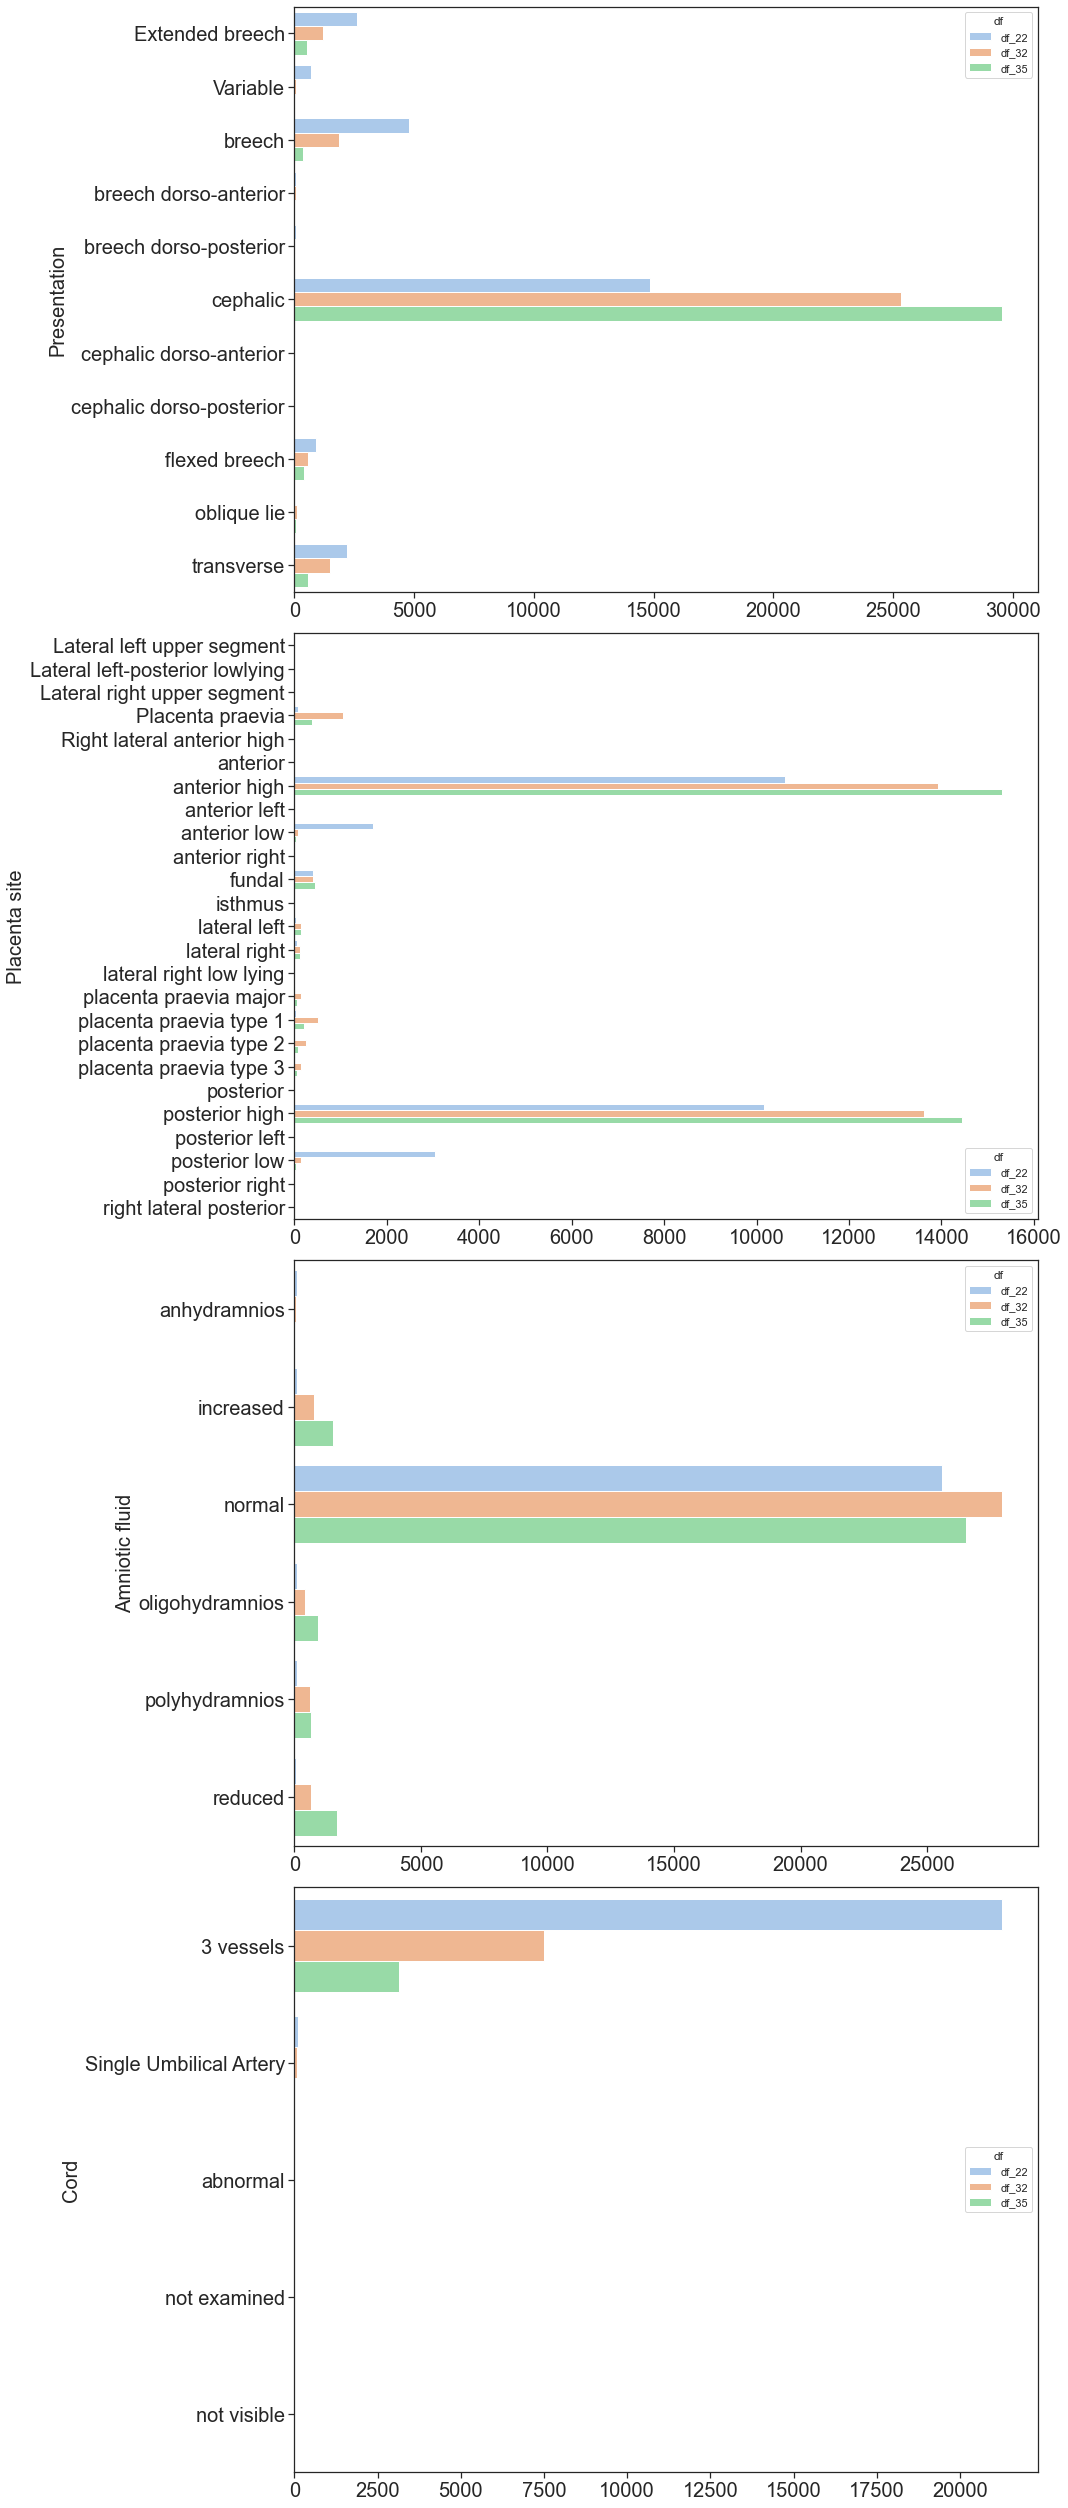

In [68]:
visualize_cat(cat_cols, df_22, df_32, df_35)

In [69]:
#clean up outliers then visualize again

#cleaning outliers
def clean_outliers_zscore(df):
    z_score_list = df.select_dtypes('float64')

    for col in df.columns: #get z_score
        if col in z_score_list:
            col_zscore = col + "_zscore"
            df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0) 
            #if 1, then it will divide by n-1, unbiased in samplling (but in our case not sampling so we use ddof=0)

    rows_to_remove = []
    col_to_remove = []
    for col in df:
        if 'zscore' in col:
            col_to_remove.append(col)
            rows_to_remove +=  [i for i in df[ abs(df[col]) > 3].index] #filter outliers

    rows_to_remove = list(set(rows_to_remove))

    df.drop(rows_to_remove, inplace=True) #drop outliers
    df = df.loc[:, ~df.columns.str.endswith('zscore')]
    
    return df

In [73]:
df_35_cleaned.shape

(28916, 47)

In [77]:
df_22_cleaned = clean_outliers_zscore(df_22)
df_32_cleaned = clean_outliers_zscore(df_32)
df_35_cleaned = clean_outliers_zscore(df_35)

a,b,c = set(df_22_cleaned.select_dtypes('float64').columns), \
        set(df_32_cleaned.select_dtypes('float64').columns), \
        set(df_35_cleaned.select_dtypes('float64').columns)

common_features = a.intersection(b).intersection(c)            

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2243297767.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)


C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

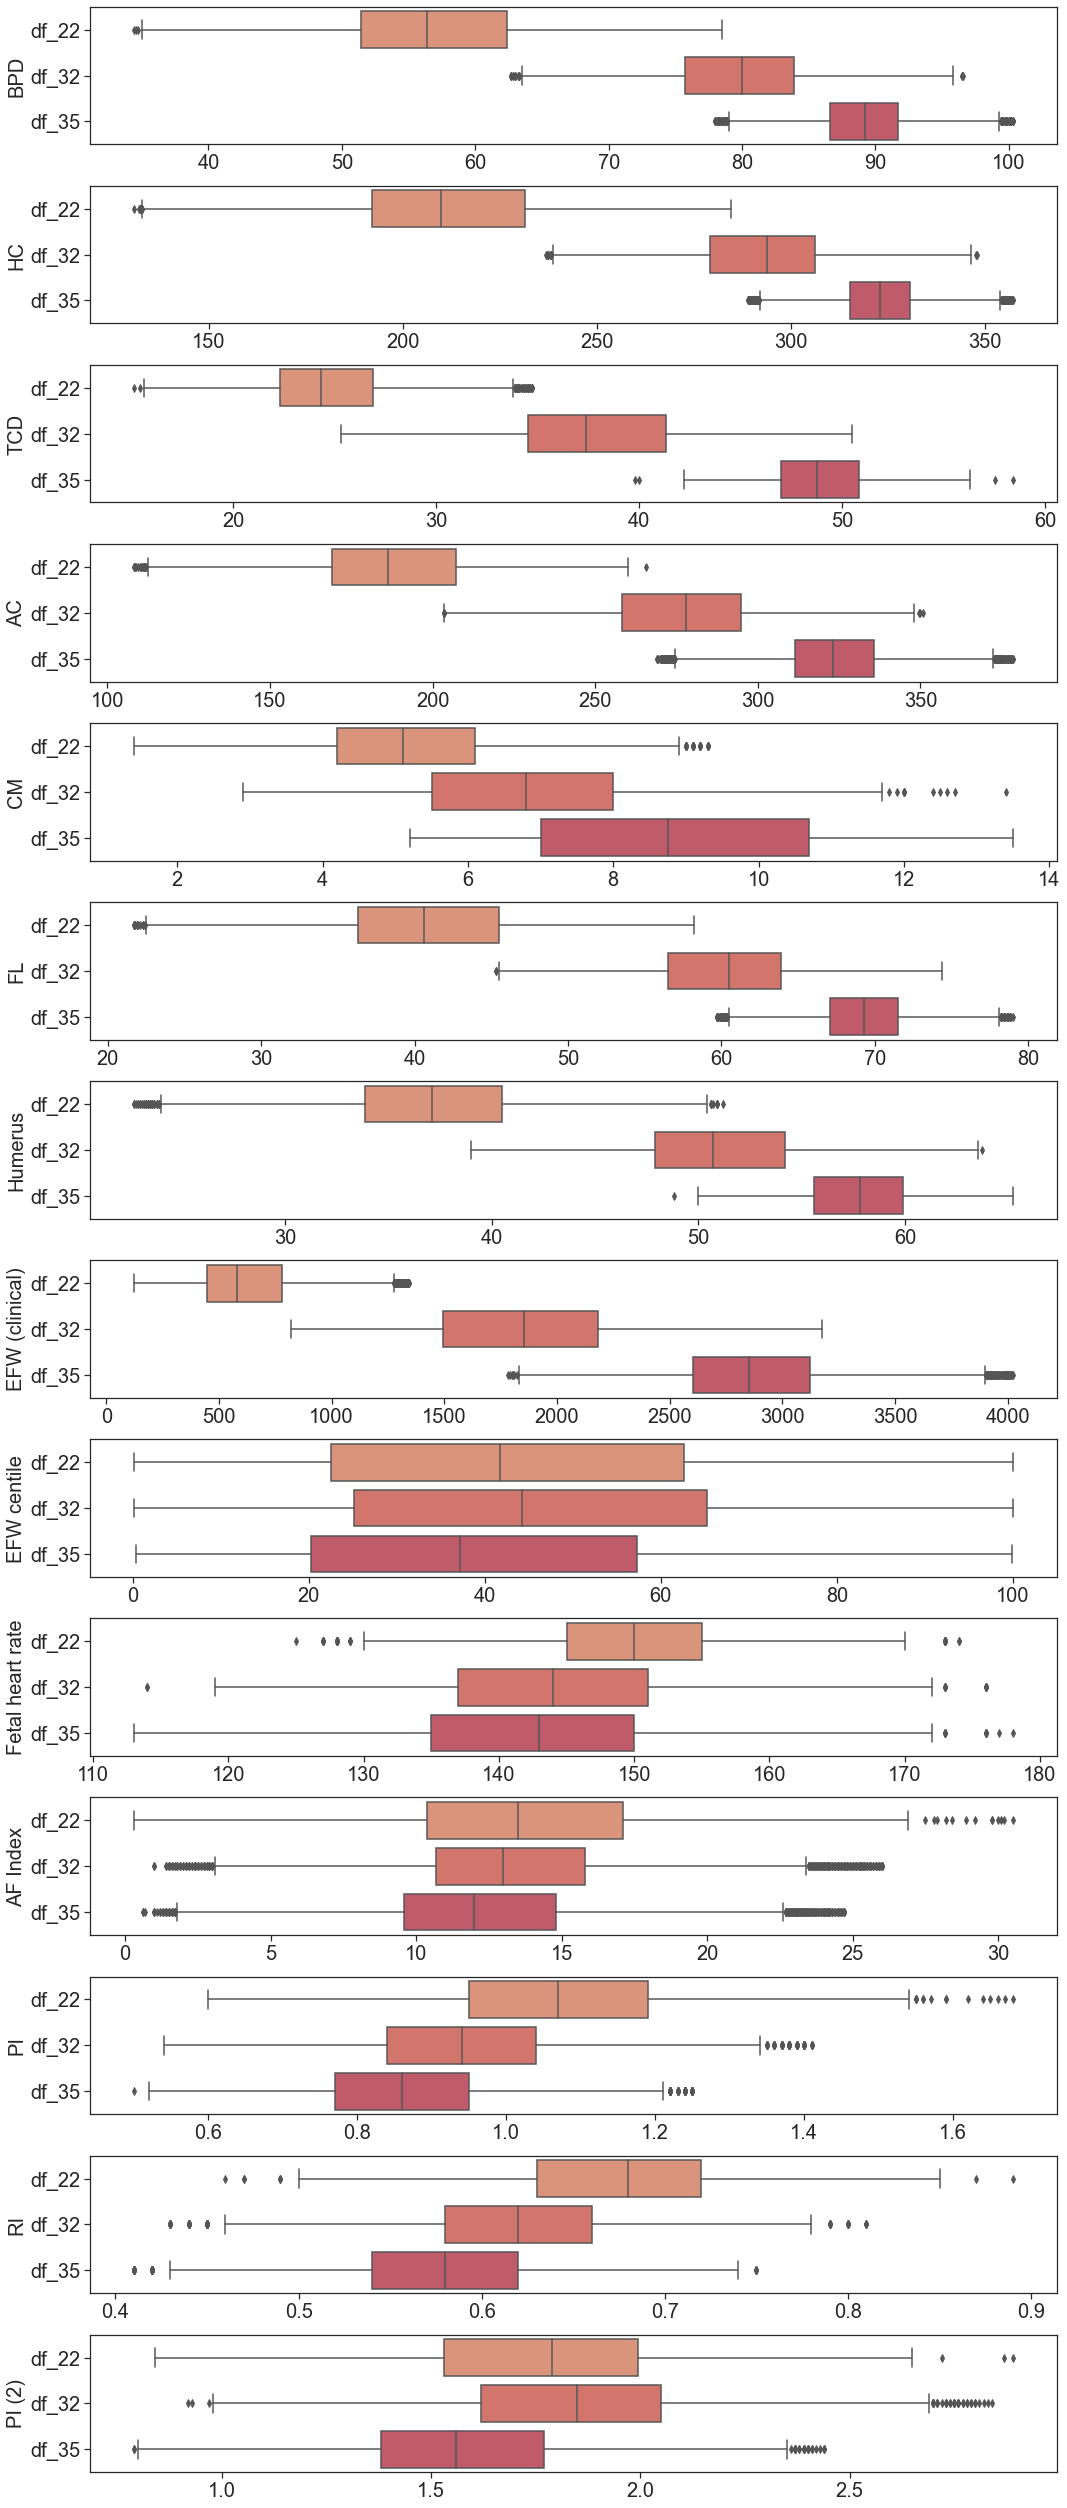

In [89]:
#wk22 --- wk32 --- wk35 (CLEANED)
visualize_val_edit(value_cols[:len(value_cols)//2], df_22_cleaned, df_32_cleaned, df_35_cleaned)

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/761764752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

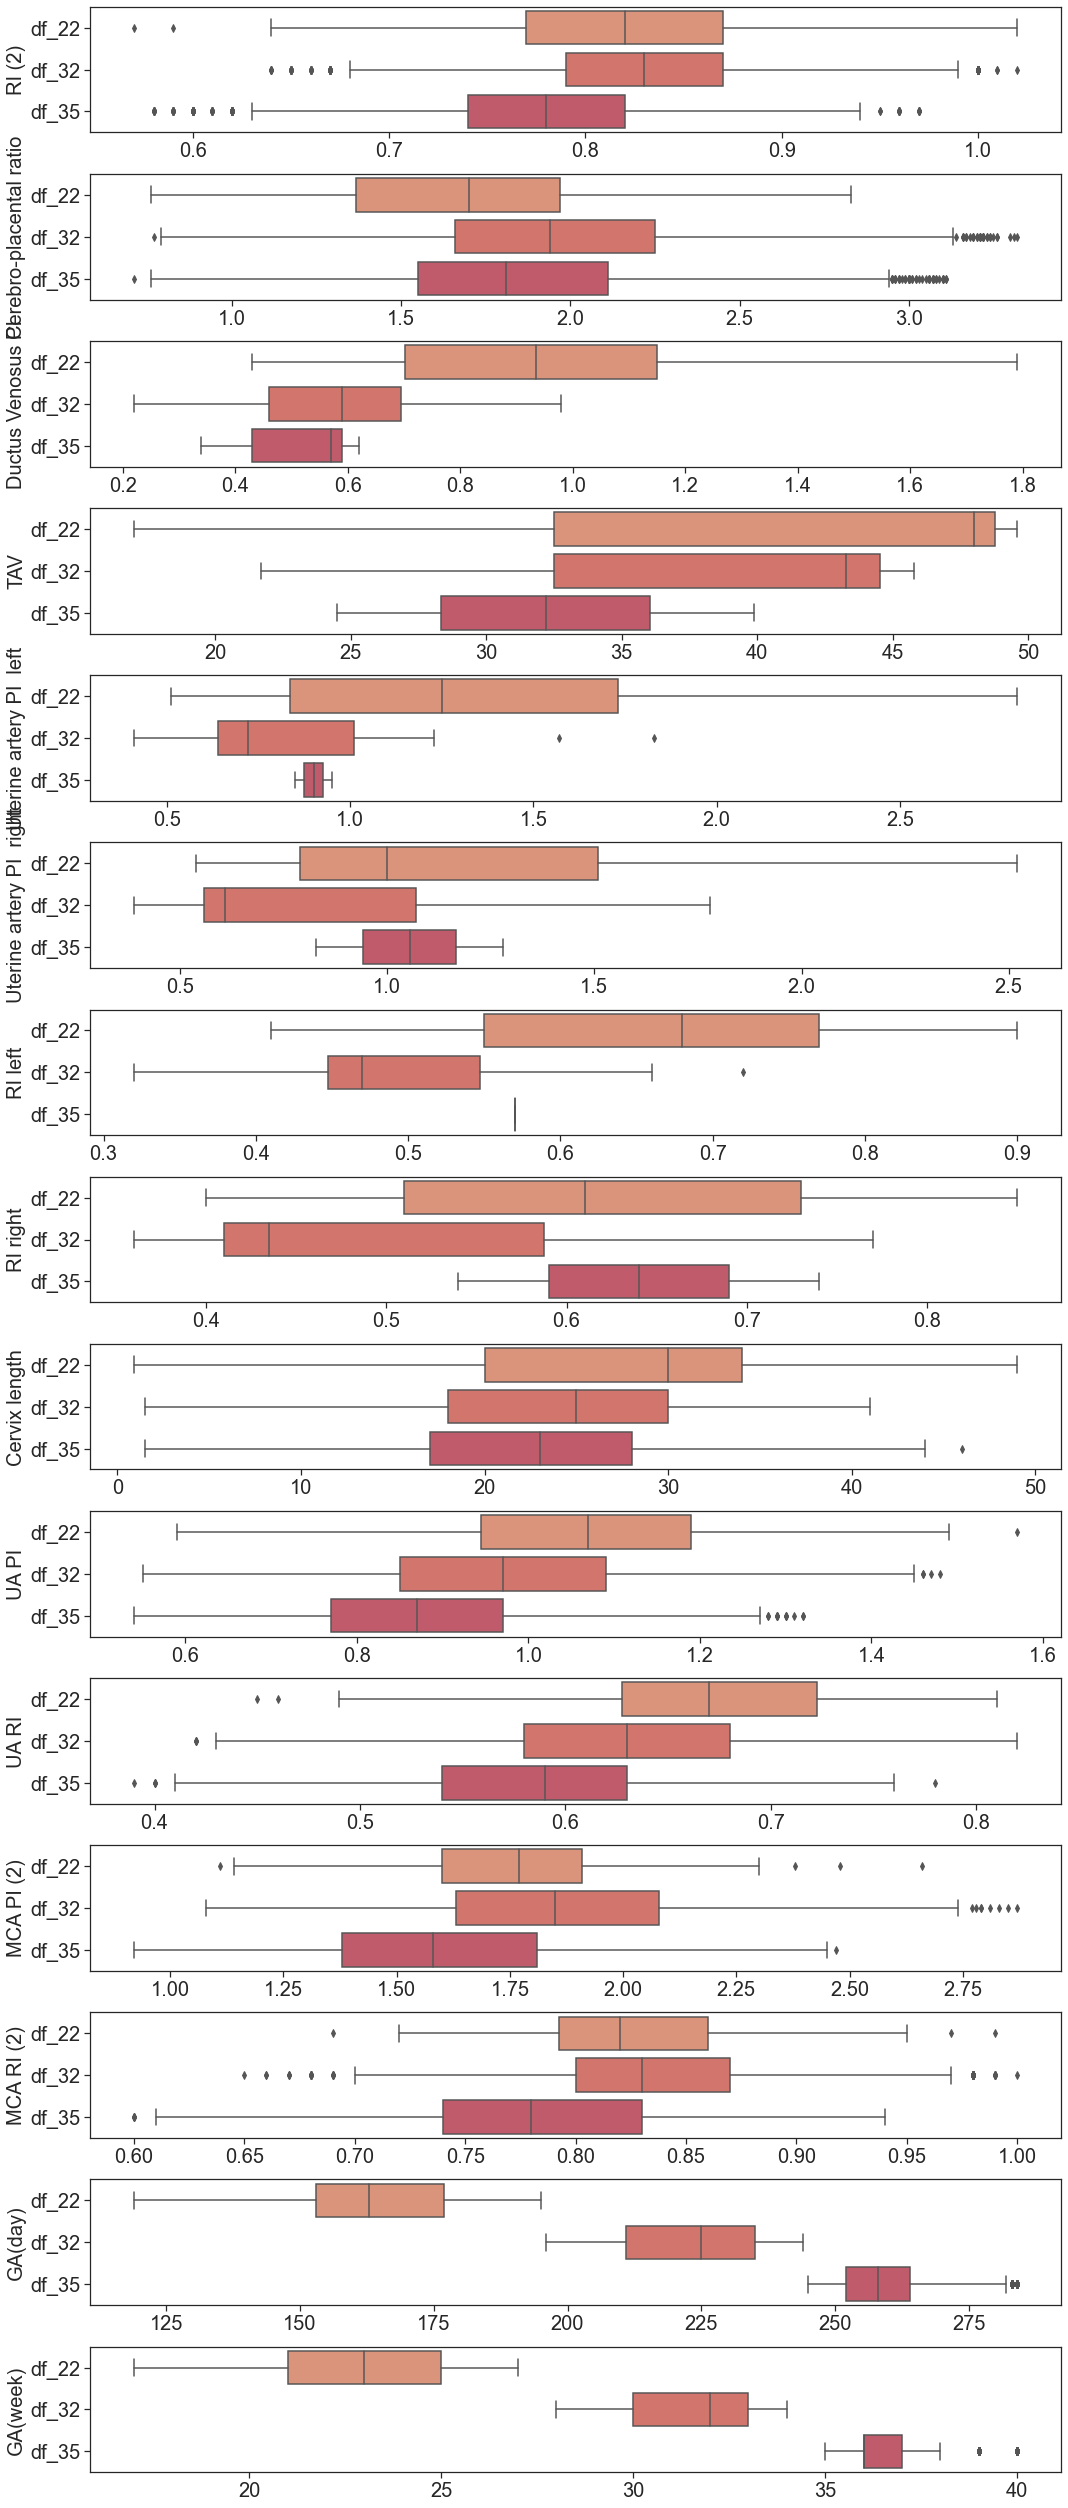

In [90]:
#wk22 --- wk32 --- wk35 (CLEANED)
visualize_val_edit(value_cols[len(value_cols)//2:], df_22_cleaned, df_32_cleaned, df_35_cleaned)

C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['df'] = 'df_22'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_32['df'] = 'df_32'
C:\Users\yc_go\AppData\Local\Temp/ipykernel_13004/2565962428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

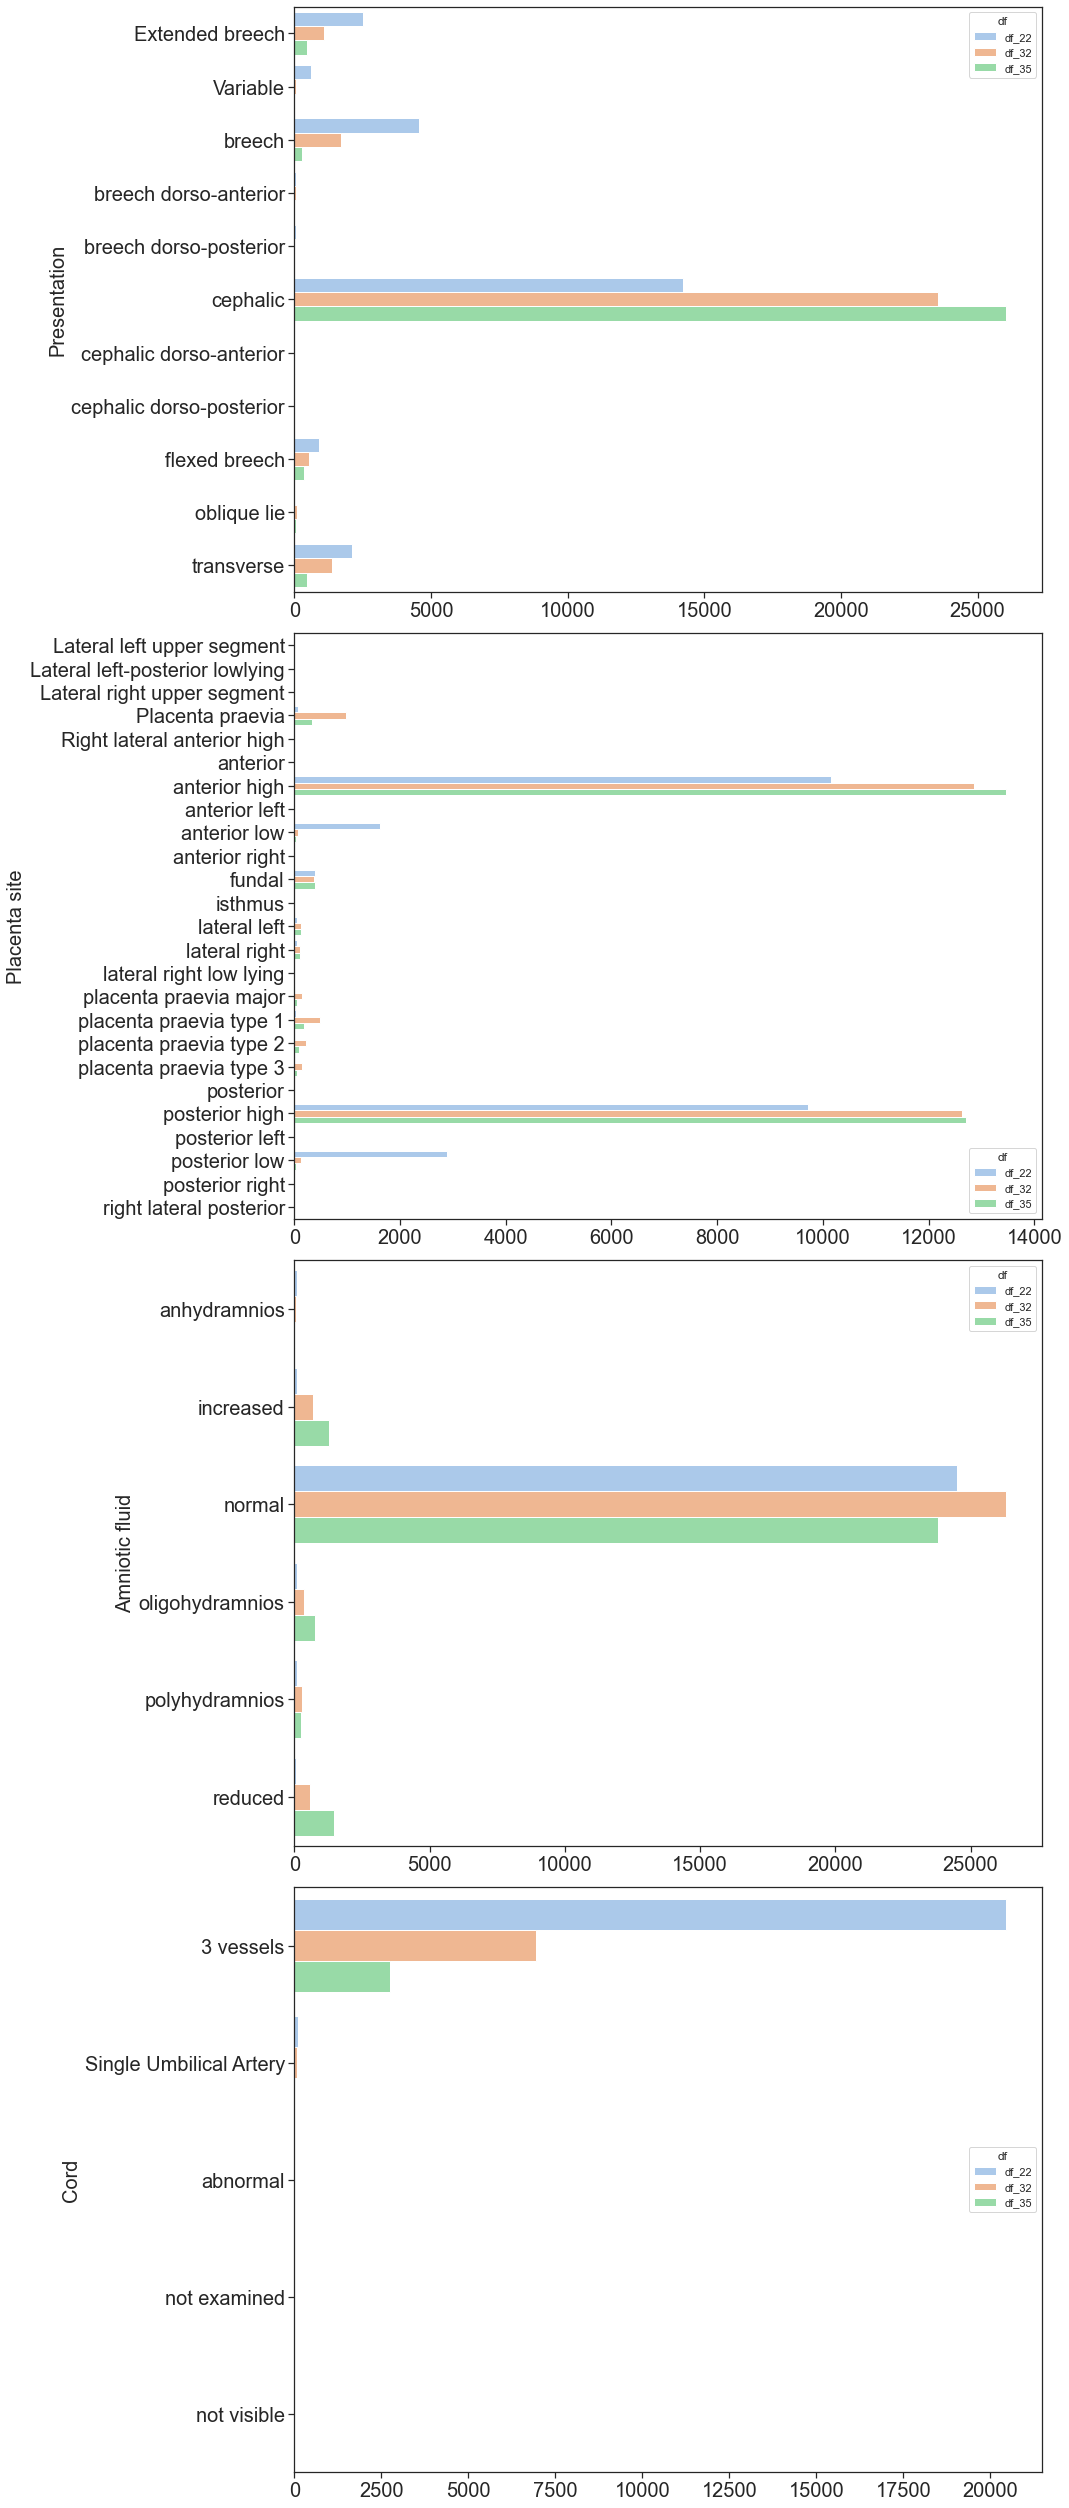

In [91]:
visualize_cat(cat_cols, df_22_cleaned, df_32_cleaned, df_35_cleaned)

### Summary:

From wk22 > wk32 > wk35: Float columns

1. Increasing:
	- BPD (55|80|90) 
        - the diameter of your baby's head/ The biparietal diameter (BPD) is measured as an outer-to-inner cranial measurement
	- HC  (210|290|320) 
        -  The occipitofrontal diameter (OFD) as the distance between the middle of the bone echoes. The head circumference is calculated by the formula: HC = 1.62 × (BPD + OFD).
	- TCD (24|37|48)
        - Fetal transverse cerebellar diameter
        - It is measured as the maximal diameter between the cerebellar hemispheres on an axial scan.
        - Is it hem in previous study? NO
	- AC  (180|275|320)
         - abdominal circumference -> circumference of the fetal abdomen (body space between the chest and pelvis)
	- CM  (5|7|10)
        - cisterna magna is the space between the inferior margin of the vermis and the posterior rim of the foramen magnum
        - Inferior margin –> inferior border. The caudal or lowermost margin of a structure.
        - Vermis is the unpaired, median portion of the cerebellum that connects the two hemispheres （小脑）
        - Posterior -> further back in position; of or nearer the rear or hind end.
        - Foramen magnum is the largest foramen of the skull
        - In short it is the space between those 2 things at the skull.
	- FL  (40|60|70) 
        - Femur length (FL) -> Measures the longest bone in the body and reflects the longitudinal growth of the fetus.
	- Humerus (38|50|58)
        - Humerus is the arm bone between your shoulder and your elbow.
	- EFW (600|1850|2900)
        - Estimated Fetal Weight
	- Cerebro-placental ratio (1.75|2|1.9)
        - Cerebroplacental ratio (CPR) is an obstetric ultrasound tool used as a predictor of adverse pregnancy outcome in both small for gestational age (SGA) and appropriate for gestational age (AGA) fetuses.
        - 
	- GA(day) (160|225|258)
	- GA(week) (23|32|36.5)
    
    
2. Remain:
	- EFW centile (40|40|40)
	- Uterine artery PI left (1.35|0.9|0.93)
        - Uterus's artery
        - Pulsatility index (PI) (also known as the Gosling index) is a calculated flow parameter in ultrasound, derived from the maximum, minimum, and mean Doppler frequency shifts during a defined cardiac cycle.
        - A high uterine artery pulsatility index reflects a defective development of placental bed spiral arteries in pregnancies complicated by hypertension and fetal growth retardation.
        
        - The mean PI in the right and left uterine artery are 1.09 and 0.81, with a range of 0.53 - 1.58 and 0.58 - 1.83 respectively. The RI has a mean of 0.59 and 0.65, while the range was 0.37-1.16 and 0.41 - 0.82 in both the right and left uterine artery respectively.
        
	- Ductus Veneous PI (1|0.625|0.6)
        - A shunt that allows oxygenated blood in the umbilical vein to bypass the liver and is essential for normal fetal circulation.
        - In medicine, a shunt is a hole or a small passage which moves, or allows movement of, fluid from one part of the body to another.
	- RI(2) (0.82|0.83|0.75)
        - Resistance Index is a measure of pulsatile blood flow that reflects the resistance to blood flow caused by microvascular bed distal to the site of measurement.
    
    
3. Decreasing:
	- Fetal heart rate (150|145|140)
	- AF index (13|12|12)
        - The sum of the deepest vertical pocket of fluid.
        - A normal amniotic fluid index is 5 cm to 25 cm using the standard assessment method. Less than 5 cm is considered oligohydramnios, and greater than 25 cm is considered polyhydramnios.
	- PI (1|1|0.9)
        - Pulsatility index
	- RI (0.68|0.62|0.58)
        - Resistance index
	- PI(2) (1.9|1.8|1.6)
	- TAV (47|28|24)
        - time-averaged velocity
        - https://radiopaedia.org/articles/umbilical-arterial-doppler-assessment
        - umbilical arterial S/D ratio (SDR): systolic velocity / diastolic velocity
        - pulsatility index (PI) (Gosling index): (PSV - EDV) / TAV
        - resistive index (RI) (Pourcelot index): (PSV - EDV) / PSV
        - PSV: peak systolic velocity
        - EDV: end-diastolic velocity
        - TAV: time-averaged velocity

	- Cervix Length (30|26|28)
        - A cylinder-shaped neck of tissue that connects the vagina and uterus.
	- UA PI (1.1|0.95|0.9)
        - Uterine Artery Pusatility index(mentioned before)
	- UA RI (0.68|0.62|0.59)
        - Uterine Artery Resistance index
	- MCA PI(2) (1.8|1.9|1.6)
        - Fetal middle cerebral arterial (MCA) Doppler assessment is an important part of assessing fetal cardiovascular distress, fetal anemia or fetal hypoxia.
	- MCA RI(2) (0.82|0.82|0.78)
    
    
4. Unclear:
	- Uterine artery PI right (1.1|0.95|1.28)
	- RI right (0.62|0.53|0.66)
	- RI left (0.7|0.52|0.565)
    
From wk22 > wk32 > wk35: Category columns

1. Presentation: The way that the fetus presented.
     - Extended breech, variable, breech, flexed breech and transverse mostly become cephalic
- Placenta site:
     - posterior low, anterior low become less, placenta praevia increase then decrease.
- Amniotic fluid:
     - Gradually become more variations
- Cord:
     - Remain 3 Vessels 
         - baby's “supply line” because it carries the baby's blood back and forth, between the baby and the placenta.

## Comparing to previous data

|Prev | Now |
|-|-|
| EFW_22 | EFW (Clinical) |
| GA(Day)_22 | GA(day) |
| Baby Gender_22 | None |
| CM_22 | CM |
| Ut PI_22 | UA PI / left / right |
| Va_22 | None |
| Nuchal fold_22 | None |
| Hem_22 | None |
| BPD_22 | BPD |
| GA(Week)_32 | Yes |
| EFW_32 | Yes |

In [29]:
df_master.columns

Index(['PID', 'Case number', 'Exam', 'Fetus', 'Hospital no.', 'Ethnic_group',
       'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW (clinical)',
       'EFW centile', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'AF Index', 'Amniotic fluid', 'Cord', 'PI', 'RI', 'EDF', 'PI (2)',
       'RI (2)', 'Cerebro-placental ratio', 'A-wave', 'Ductus Venosus PI',
       'TAV', 'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
       'RI right', 'Notch', 'Funnelling', 'Cervix length',
       'Estimated fetal weight', 'Examination date', 'UA PI', 'UA RI',
       'MCA PI (2)', 'MCA RI (2)', 'GA(day)', 'GA(week)', 'df_cat'],
      dtype='object')

In [94]:
columns_to_drop = ['PID', 'Case number', 'Exam', 'Fetus','Hospital no.', 'EFW centile', ]

<AxesSubplot:>

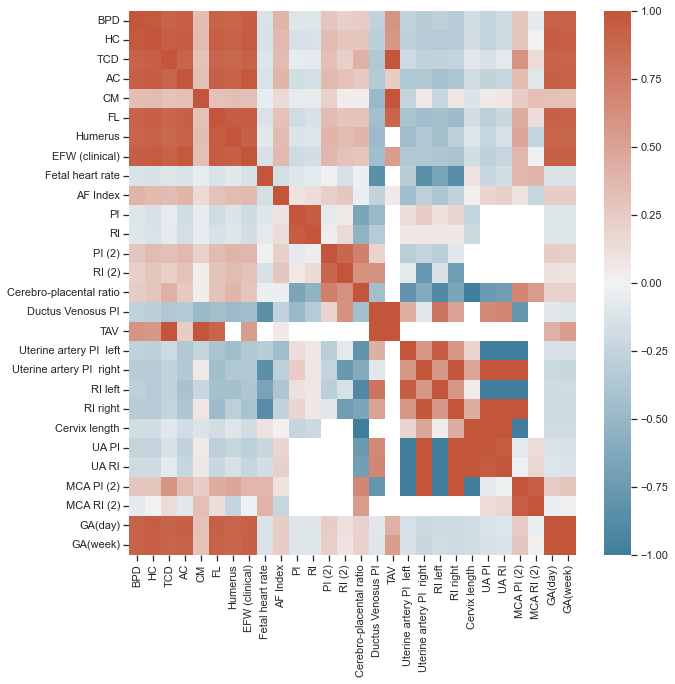

In [96]:
df_22 = df_22_cleaned
df_32 = df_32_cleaned
df_35 = df_35_cleaned

# correlation graph
f, ax = plt.subplots(figsize=(10,10))
corr = df_22.drop(columns_to_drop, axis=1).corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

#From the correlation graph:
#1. Removed Highly Correlated features with non-target
#2. Understand that none of the features has high correlation with target.

# Mergingg
1. Rename
- Take Hospital no., GA(week) and EFW(clinical) of respective week 
    - Wk22 + GA(Week)32 -> EFW wk32
    - Wk22 + GA(Week)35 -> EFW wk35
    - WK32 + GA(Week)35 -> EFW wk35
    - WK22 + WK32 + GA(Week)35 -> EFW wk35
    
- Remove not null < 400
- Get non-null columns of the most common features (~20000 non-null)
- Remove not null again < 400
- Clean Category

In [142]:
df_22

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat,BPD_zscore,HC_zscore,TCD_zscore,AC_zscore,CM_zscore,FL_zscore,Humerus_zscore,EFW (clinical)_zscore,EFW centile_zscore,Fetal heart rate_zscore,AF Index_zscore,PI_zscore,RI_zscore,PI (2)_zscore,RI (2)_zscore,Cerebro-placental ratio_zscore,Ductus Venosus PI_zscore,TAV_zscore,Uterine artery PI left_zscore,Uterine artery PI right_zscore,RI left_zscore,RI right_zscore,Cervix length_zscore,UA PI_zscore,UA RI_zscore,MCA PI (2)_zscore,MCA RI (2)_zscore,GA(day)_zscore,GA(week)_zscore
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22,-1.282460,-1.517427,-0.964686,-1.134192,-0.088972,-1.230336,NaN,-1.119432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.890601,-0.832435
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,7.9,37.1,NaN,452.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22,-0.810561,-0.554815,-0.906017,-0.693167,1.801694,-0.539412,NaN,-0.708543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.539593,-0.421455
18,30,1,1,1,29779790,NaN,50.7,191.7,23.3,168.6,4.2,37.9,NaN,459.0,NaN,NaN,Extended breech,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22,-0.785053,-0.696898,-0.407328,-0.685996,-0.696686,-0.419251,NaN,-0.680344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.539593,-0.421455
22,34,1,1,1,27591077,NaN,46.8,175.1,22.2,151.6,5.1,32.4,NaN,340.0,NaN,NaN,breech,fundal,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,145.0,20.0,wk22,-1.282460,-1.286542,-0.730009,-1.295543,-0.088972,-1.245356,NaN,-1.159715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.124607,-1.243416
27,38,1,1,1,12350378,NaN,51.2,190.7,22.1,163.8,6.0,34.8,NaN,410.0,NaN,NaN,Extended breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,142.0,20.0,wk22,-0.721283,-0.732419,-0.759344,-0.858103,0.518742,-0.884874,NaN,-0.877732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.300111,-1.243416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16770,43833,1,1,1,36156922,NaN,47.1,174.7,20.9,162.3,4.1,31.9,NaN,364.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,148.0,21.0,wk22,-1.244198,-1.300751,-1.111359,-0.911887,-0.764210,-1.320456,NaN,-1.063035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.949103,-0.832435
16771,43834,1,1,1,13274179,NaN,46.3,171.1,20.1,156.0,5.2,32.0,NaN,346.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,142.0,20.0,wk2

In [143]:
df_32_output = df_32[['Hospital no.', 'GA(week)', 'EFW (clinical)']]
df_35_output = df_35[['Hospital no.', 'GA(week)', 'EFW (clinical)']]

df_32_output = df_32_output.rename(columns={'GA(week)': 'GA(week)_32', 'EFW (clinical)': 'EFW_32'})
df_35_output = df_35_output.rename(columns={'GA(week)': 'GA(week)_35', 'EFW (clinical)': 'EFW_35'})

In [144]:
df_22_32 = pd.merge(df_22, df_32_output, on='Hospital no.', how='inner')
df_22_32 = df_22_32.rename(columns={'Estimated fetal weight': 'EFW Formulae', 'EFW (clinical)': 'EFW_22'})

df_32_35 = pd.merge(df_32, df_35_output, on='Hospital no.', how='inner')
df_32_35 = df_32_35.rename(columns={'Estimated fetal weight': 'EFW Formulae', 'EFW (clinical)': 'EFW_32'})

## df22 -> efw_32

In [145]:
null_threshold = 400
to_drop = list(df_22_32.loc[:, df_22_32.isnull().sum() > (df_22_32.shape[0] - null_threshold)])
df_22_32_v2 = df_22_32.drop(to_drop, axis=1)
df_22_32_v2 = df_22_32_v2.drop(['PID', 'Case number', 'Exam', 'Fetus', 'EFW centile'], axis=1)

df_22_32_v2 = df_22_32_v2[   ~df_22_32_v2['BPD'].isnull() &
                             ~df_22_32_v2['HC'].isnull() & 
                             ~df_22_32_v2['TCD'].isnull() & 
                             ~df_22_32_v2['AC'].isnull() & 
                             ~df_22_32_v2['CM'].isnull() &
                             ~df_22_32_v2['Presentation'].isnull() &
                             ~df_22_32_v2['Placenta site'].isnull() &
                             ~df_22_32_v2['Amniotic fluid'].isnull() &
                             ~df_22_32_v2['Cord'].isnull() 
                            ]

df_22_32_v2 = df_22_32_v2[df_22_32_v2['Cord'].isin(['3 vessels', 'Single Umbilical Artery', 'abnormal'])]

In [146]:
to_drop_v2 = list(df_22_32_v2.loc[:, df_22_32_v2.isnull().sum() > (df_22_32_v2.shape[0] - null_threshold)])
df_22_32_v3 = df_22_32_v2.drop(to_drop_v2, axis=1)

#clean up unused categories
cat_cols = df_22_32_v3.select_dtypes(include=['category']).columns

for col in cat_cols:
    df_22_32_v3[col] = df_22_32_v3[col].cat.remove_unused_categories()

In [147]:
df_22_32_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18007 entries, 0 to 28426
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospital no.             18007 non-null  object        
 1   BPD                      18007 non-null  float64       
 2   HC                       18007 non-null  float64       
 3   TCD                      18007 non-null  float64       
 4   AC                       18007 non-null  float64       
 5   CM                       18007 non-null  float64       
 6   FL                       18007 non-null  float64       
 7   Humerus                  9722 non-null   float64       
 8   EFW_22                   18007 non-null  float64       
 9   Fetal heart rate         2459 non-null   float64       
 10  Presentation             18007 non-null  category      
 11  Placenta site            18007 non-null  category      
 12  Amniotic fluid           18007 n

# Model Training Data 

## Pycaret

1. Humerus + Fetal heart rate -> not null
    - Shape: (2468, 47)
    - RMSE: 211.8449 
2. Use Fetal heart rate only
    - Shape: (2649, 46)
    - RMSE: 208.8975
3. Use Humerus 
    - Shape: (10492, 48)
    - RMSE: 213.2135
    - R2: 0.7838
4. Drop both:
    - Shape: (19425, 47)
    - RMSE: 215.4875	
    - R2: 0.7814
    
5. Use GA(week)_32 only:
    - Shape: (19425, 2)
    - RMSE: 247.2611
    - R2: 0.7123
    
** These results are so good due to GA_Week32.


think about how to restate the problem statement

In [148]:
df_22_32_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18007 entries, 0 to 28426
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospital no.             18007 non-null  object        
 1   BPD                      18007 non-null  float64       
 2   HC                       18007 non-null  float64       
 3   TCD                      18007 non-null  float64       
 4   AC                       18007 non-null  float64       
 5   CM                       18007 non-null  float64       
 6   FL                       18007 non-null  float64       
 7   Humerus                  9722 non-null   float64       
 8   EFW_22                   18007 non-null  float64       
 9   Fetal heart rate         2459 non-null   float64       
 10  Presentation             18007 non-null  category      
 11  Placenta site            18007 non-null  category      
 12  Amniotic fluid           18007 n

In [149]:
df_22_32_v3.columns

Index(['Hospital no.', 'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus',
       'EFW_22', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'Amniotic fluid', 'Cord', 'EFW Formulae', 'Examination date', 'GA(day)',
       'GA(week)', 'df_cat', 'BPD_zscore', 'HC_zscore', 'TCD_zscore',
       'AC_zscore', 'CM_zscore', 'FL_zscore', 'Humerus_zscore',
       'EFW (clinical)_zscore', 'EFW centile_zscore',
       'Fetal heart rate_zscore', 'GA(day)_zscore', 'GA(week)_zscore',
       'GA(week)_32', 'EFW_32'],
      dtype='object')

In [150]:
#cleaning outliers
#['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW (clinical)', 'Fetal heart rate', 'AF Index', 'PI', 'RI', 'GA(day)']
z_score_list = ['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL','Humerus', 'EFW (clinical)', 'Fetal heart rate', 'GA(day)',
                'GA(week)',]

for col in df_22_32_v3.columns: #get z_score
    if col in z_score_list:
        col_zscore = col + "_zscore"
        df_22_32_v3[col_zscore] = (df_22_32_v3[col] - df_22_32_v3[col].mean())/df_22_32_v3[col].std(ddof=0) 
        #if 1, then it will divide by n-1, unbiased in samplling (but in our case not sampling so we use ddof=0)
        
rows_to_remove = []
col_to_remove = []
for col in df_22_32_v3:
    if 'zscore' in col:
        col_to_remove.append(col)
        rows_to_remove +=  [i for i in df_22_32_v3[ abs(df_22_32_v3[col]) > 3].index] #filter outliers
        
rows_to_remove = list(set(rows_to_remove))

df_22_32_v3.drop(rows_to_remove, inplace=True) #drop outliers
df_22_32_v3 = df_22_32_v3.loc[:, ~df_22_32_v3.columns.str.endswith('zscore')]

In [151]:
df_22_32_v3.describe()

,BPD,HC,TCD,AC,CM,FL,Humerus,EFW_22,Fetal heart rate,GA(day),GA(week),GA(week)_32,EFW_32
count,17851.000000,17851.000000,17851.000000,17851.00000,17851.000000,17851.000000,9641.000000,17851.000000,2433.000000,17851.000000,17851.000000,17851.000000,17851.000000
mean,54.242793,202.005389,24.065963,178.90540,5.185721,38.609019,36.397749,537.923422,150.323058,158.580360,22.223909,31.311075,1838.267716
std,6.133925,22.079185,2.968448,21.69805,1.337056,5.302711,4.474682,174.304192,8.121611,13.271953,1.907585,2.040289,454.054227
min,36.400000,135.900000,15.800000,115.40000,1.700000,22.500000,22.800000,178.000000,127.000000,119.000000,17.000000,28.000000,793.000000
25%,49.900000,186.700000,21.900000,163.90000,4.200000,35.000000,33.400000,412.000000,145.000000,149.000000,21.000000,30.000000,1468.500000
50%,53.800000,200.600000,23.800000,177.80000,5.000000,38.400000,36.300000,509.000000,150.000000,158.000000,22.000000,32.000000,1835.000000
75%,58.300000,216.900000,26.000000,193.50000,6.100000,42.200000,39.500000,637.000000,155.000000,167.000000,23.000000,33.000000,2176.000000
max,73.000000,269.600000,33.200000,244.70000,9.200000,54.400000,49.900000,1216.000000,173.000000,195.000000,27.000000,34.000000,3204.000000


In [152]:
len(df_22_32_v3['Hospital no.'].unique())

8717

In [153]:
def visualize_val_single_df(df):
    value_cols = df.select_dtypes(include=['float64']).columns
    section = [math.ceil(i) for i in np.linspace(start = 0, stop = len(value_cols), num = 5)]
    for i in range(len(section)-1):
        cols = value_cols[section[i]: section[i+1]]
        fig, ax = plt.subplots(len(cols), 1, figsize=(20,20))
        for index, col in enumerate(cols):
            sns.set_palette('flare')
            a = sns.boxplot(x=col, data=df, ax=ax[index])
            a.set_xlabel('', fontsize = 20.0) # X label
            a.set_ylabel(col, fontsize=20.0)
            a.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()
    
def visualize_cat_single_df(df, hue=None):
    '''visulizing categorical data'''
    cat_cols = df.select_dtypes(include=['category']).columns
    fig, ax = plt.subplots(len(cat_cols) , 1, figsize=(20,20))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df, ax=ax[index], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

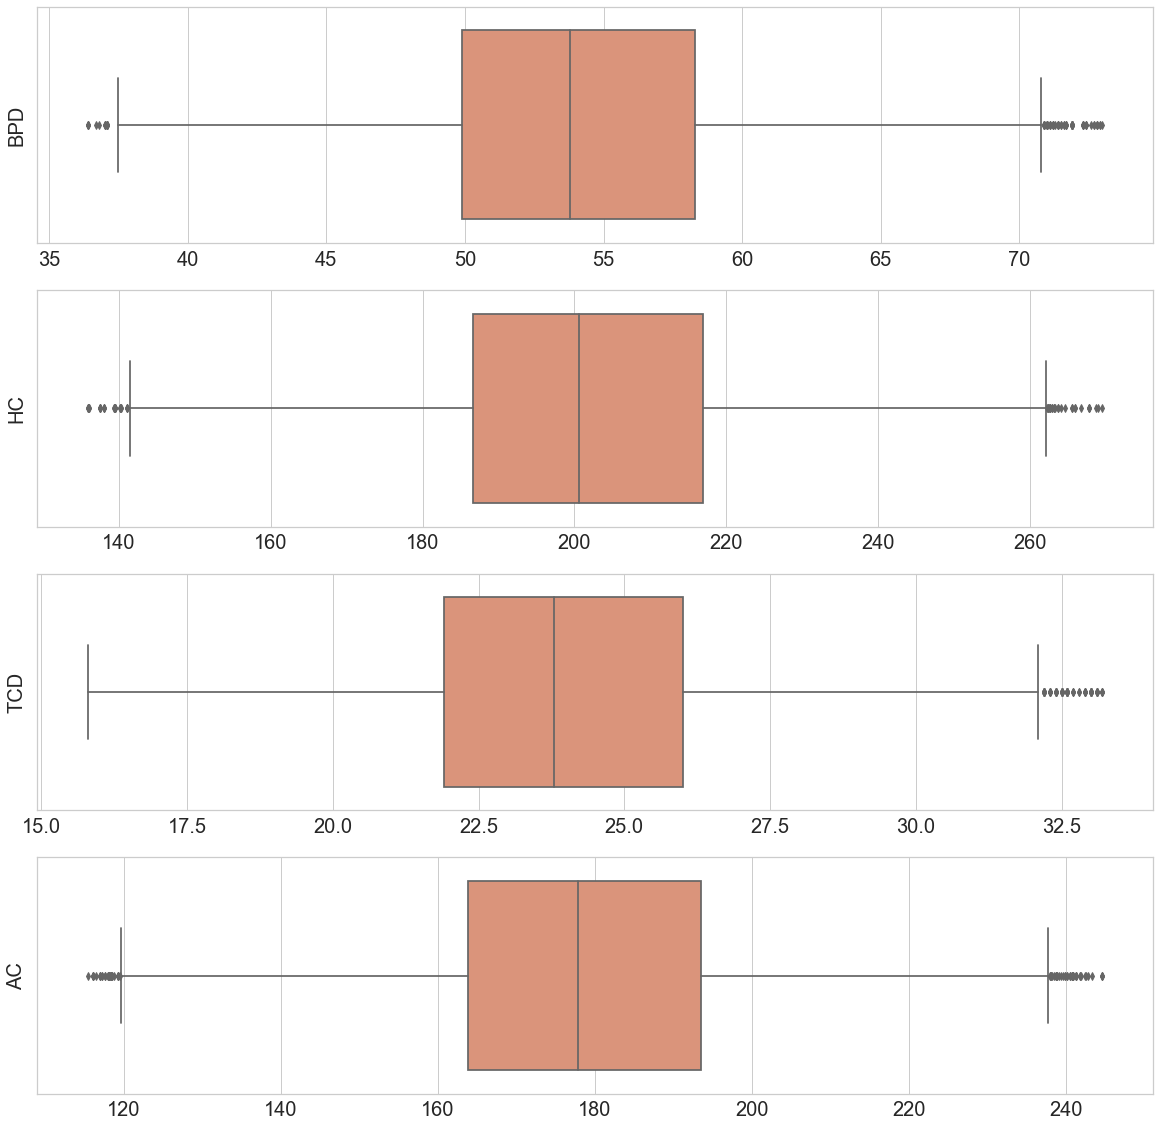

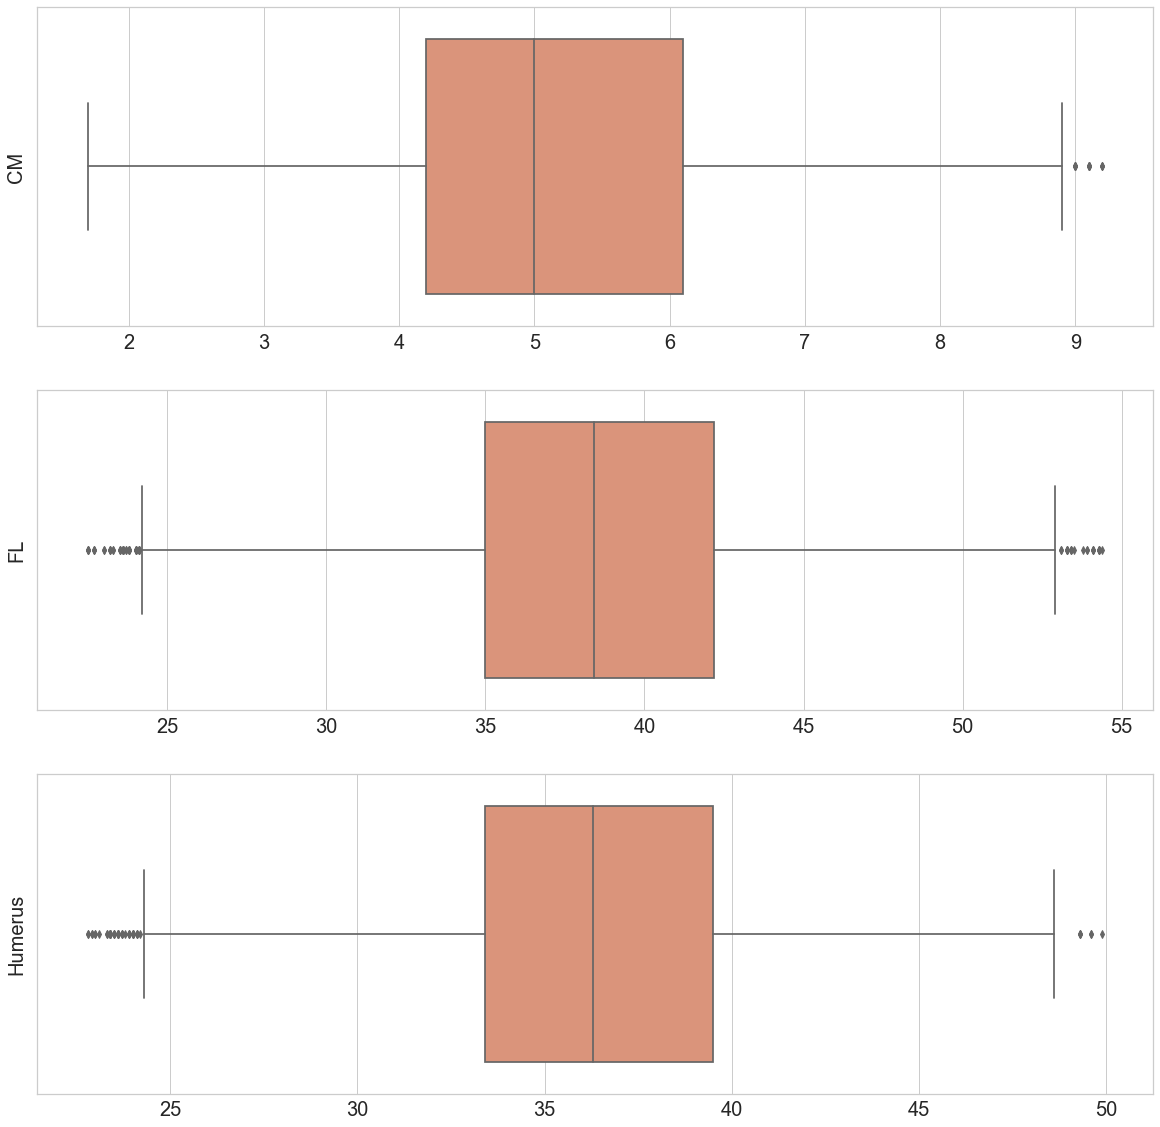

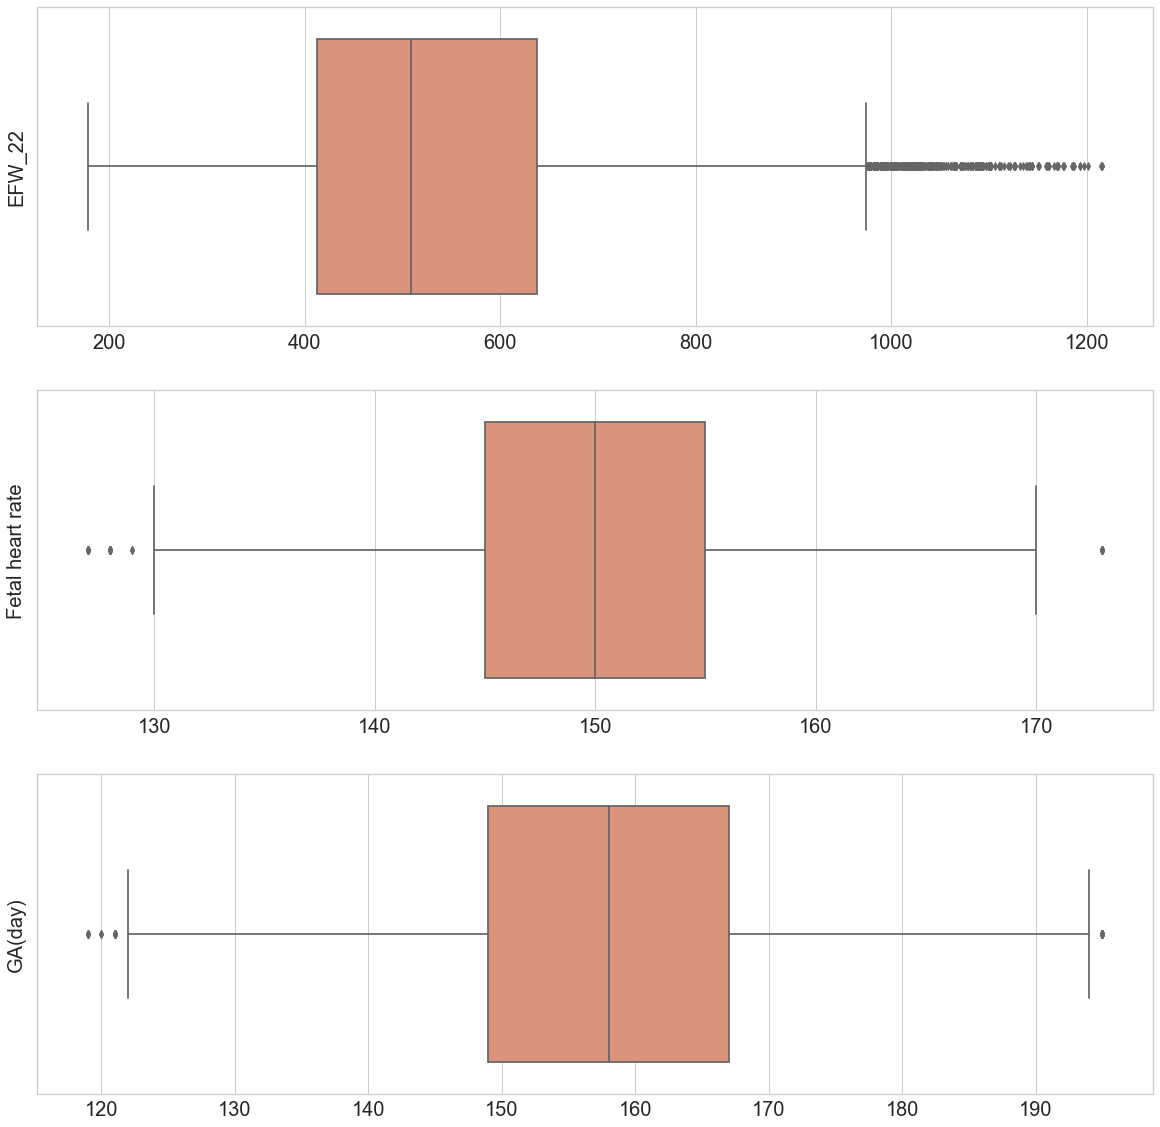

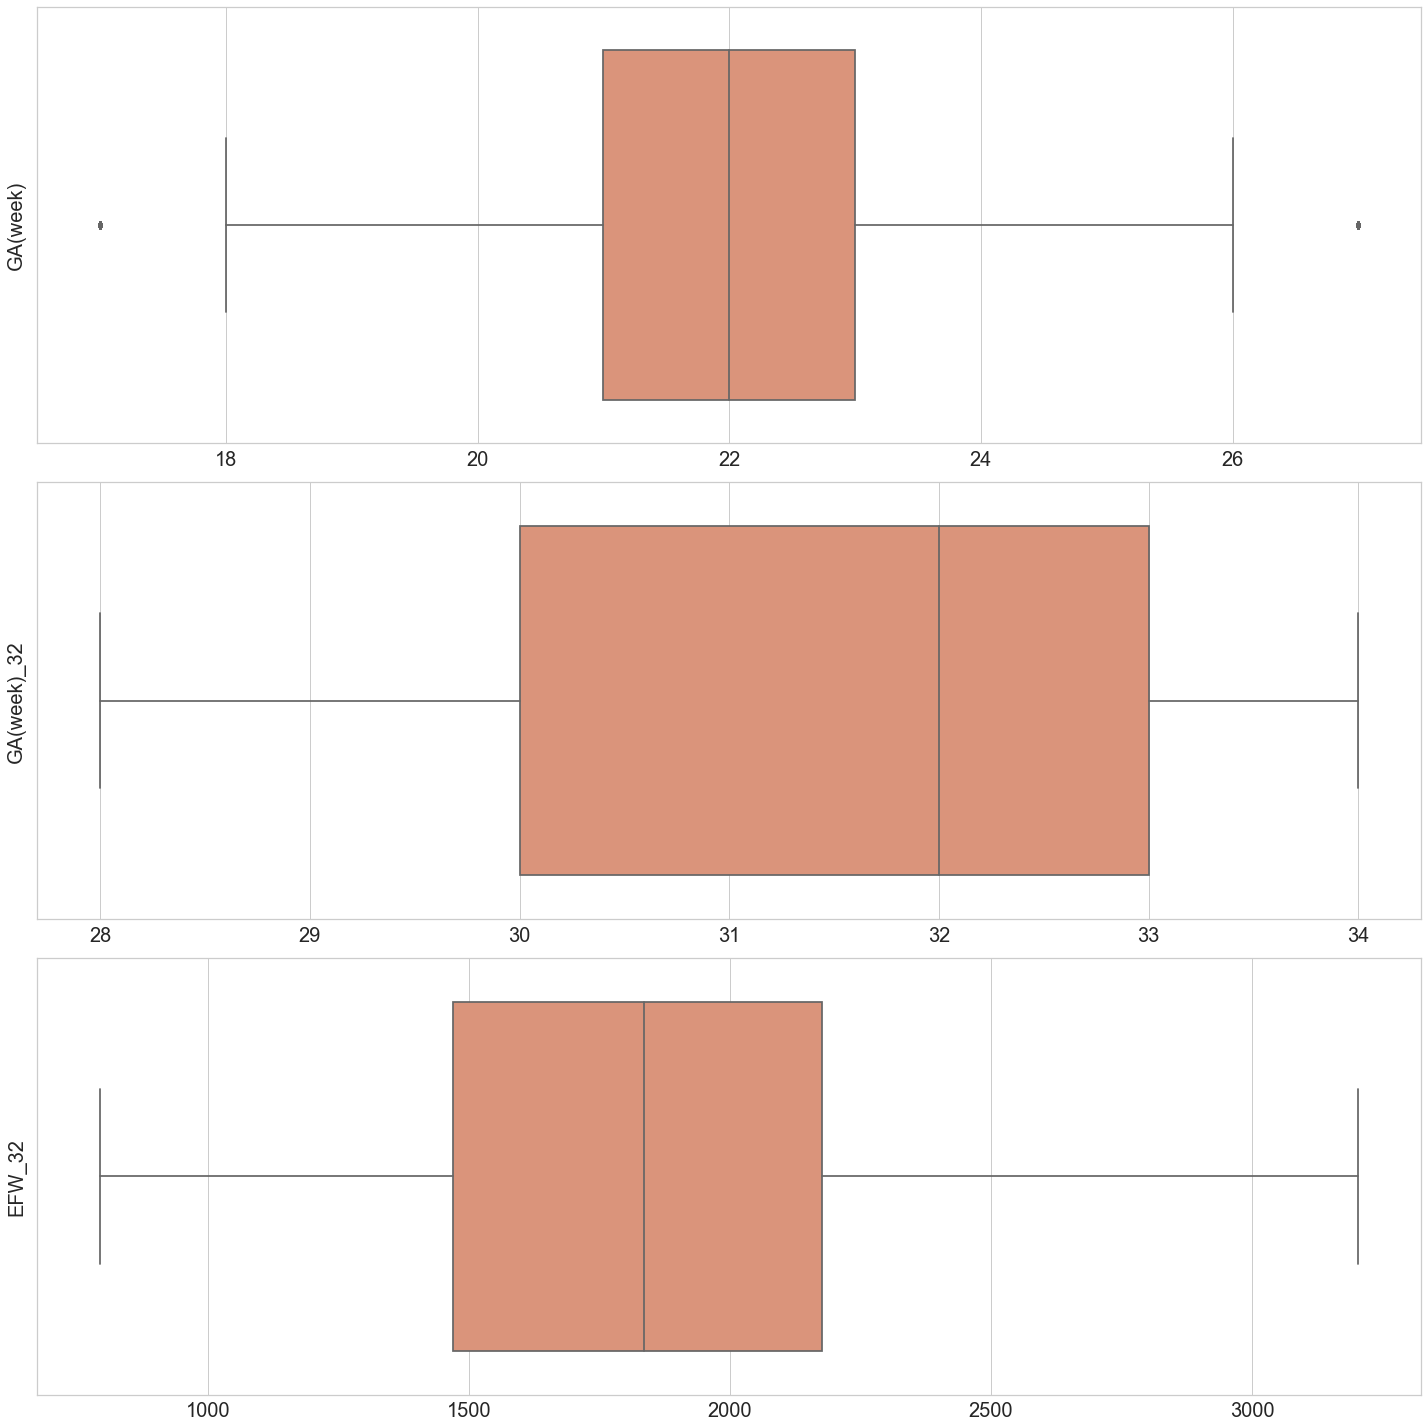

In [154]:
visualize_val_single_df(df_22_32_v3)

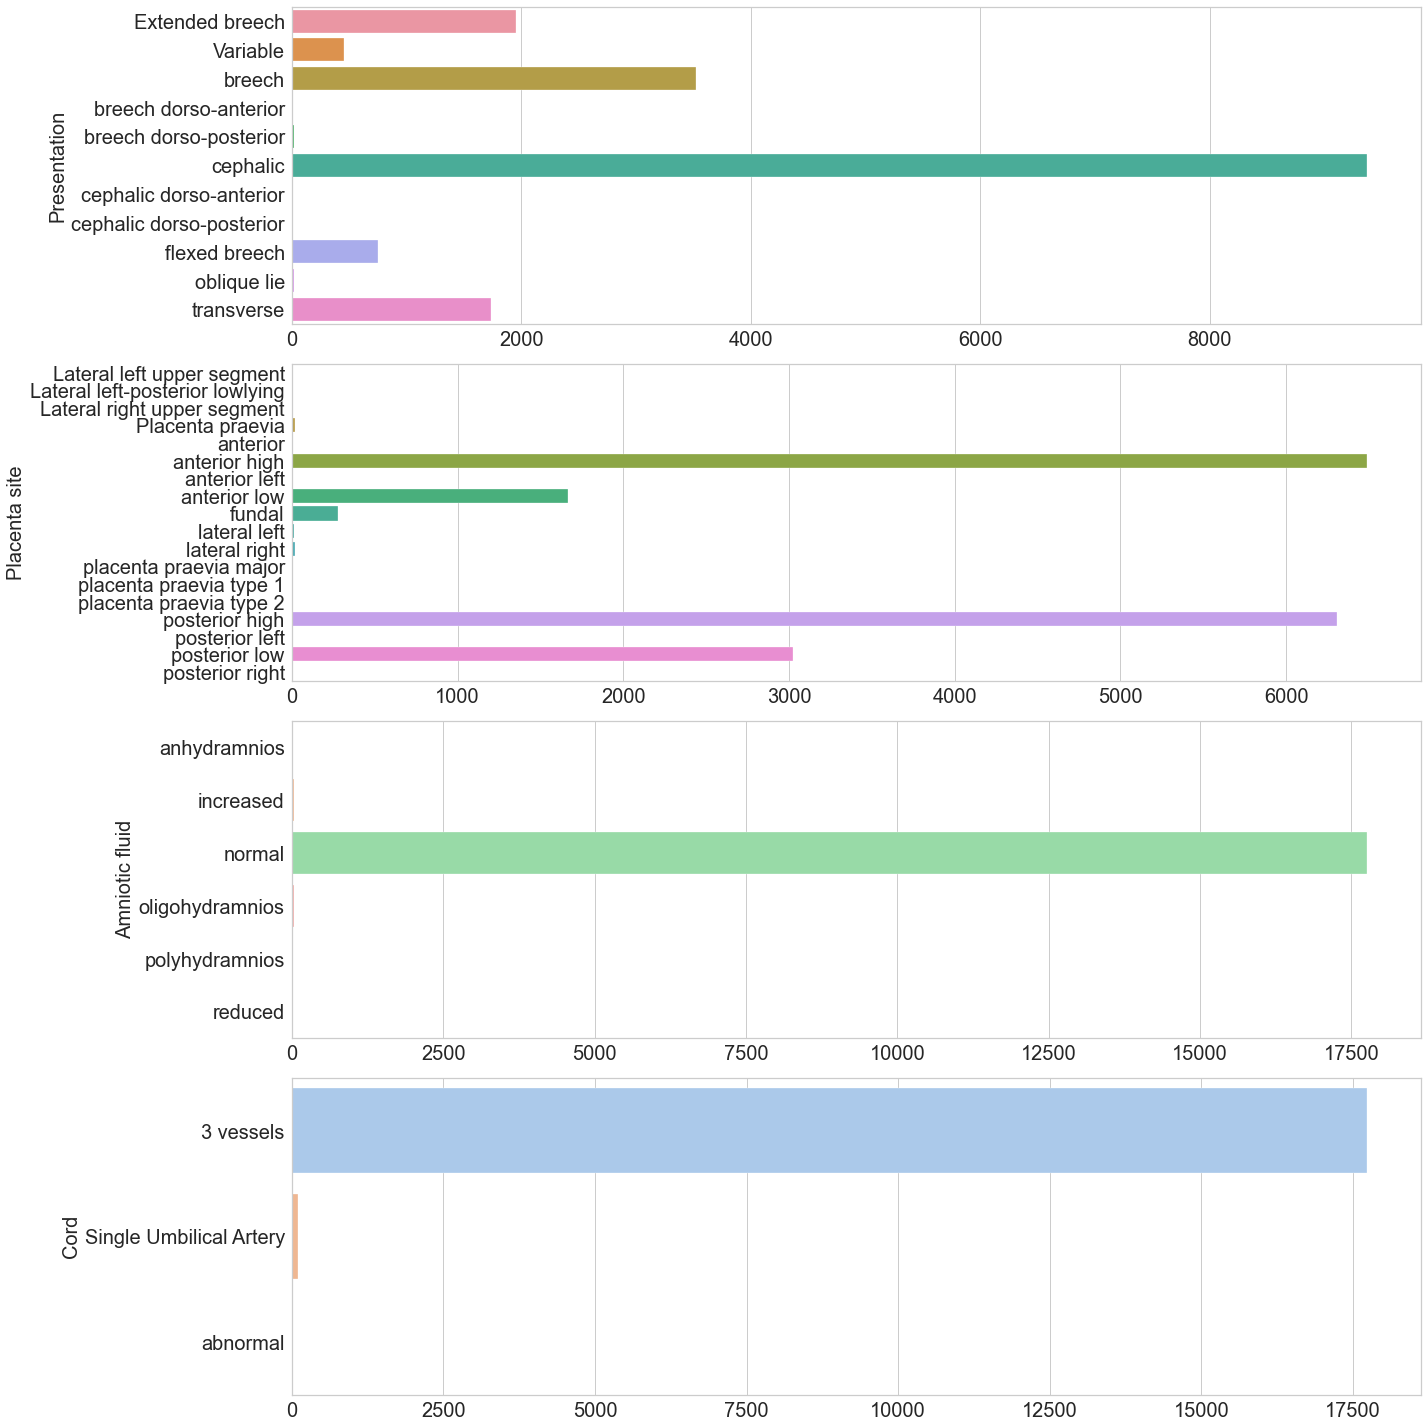

In [155]:
visualize_cat_single_df(df_22_32_v3)

## Prediction 22 -> 32

In [156]:
from pycaret.regression import *

In [157]:
# Fetal heart rate - R2 = -0.00036 (Bad)
# Humerus - R2 = 0.0092 (Bad)

# df_train_22_32 = df_22_32_v3[~df_22_32_v3['Humerus'].isnull()]
# df_train_22_32 = df_22_32_v3[~df_22_32_v3['Fetal heart rate'].isnull()]
df_train_22_32 = df_22_32_v3.drop(['Humerus', 'Fetal heart rate'], axis=1)
df_train_22_32 = df_train_22_32.drop(['Examination date', 'df_cat'], axis=1)
# df_train_22_32 = df_train_22_32.drop(['Hospital no.'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

In [158]:
df_train_22_32.columns

Index(['Hospital no.', 'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'EFW_22',
       'Presentation', 'Placenta site', 'Amniotic fluid', 'Cord',
       'EFW Formulae', 'GA(day)', 'GA(week)', 'GA(week)_32', 'EFW_32'],
      dtype='object')

In [159]:
patient_list = list(df_train_22_32['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

df_train_22_32_pycaret = df_train_22_32.loc[df_train_22_32['Hospital no.'].isin(train_patient), :]
df_train_22_32_test = df_train_22_32.loc[df_train_22_32['Hospital no.'].isin(test_patient), :]

df_train_22_32_pycaret.drop('Hospital no.', axis=1, inplace=True)
df_train_22_32_test.drop('Hospital no.', axis=1, inplace=True)

In [160]:
# df_train_22_32_test.shape
# len(df_train_22_32_test['Hospital no.'].unique())
# len(df_train_22_32_pycaret['Hospital no.'].unique())

In [161]:
check_df(df_train_22_32_test)

No null exist in this dataframe.


## Manual

In [162]:
def custom_cv(df, df_patient_list, model, target):
    kf = KFold(n_splits=10)

    r2_list =[]
    rmse_list = []
    
    dummy_cols = df.select_dtypes(include=['category', 'object']).columns
    dummy_cols = list(set(dummy_cols) - set(['Hospital no.']) )
    df = pd.get_dummies(df, columns=dummy_cols)
    
    for train_index, test_index in kf.split(df_patient_list):
        train_no = df_patient_list.loc[train_index]
        test_no = df_patient_list.loc[test_index]
        
        train_df = df[df['Hospital no.'].isin(train_no['Unique Hos no.'])]
        test_df = df[df['Hospital no.'].isin(test_no['Unique Hos no.'])]

        #drop
        train_df = train_df.drop(['Hospital no.'],axis=1)
        test_df =  test_df.drop(['Hospital no.'],axis=1)
        
        model.fit(train_df.drop(target, axis=1), train_df[target])

        y_true = test_df[target]
        y_pred = model.predict(test_df.drop(target, axis=1))

        r2_list.append(r2_score(y_true, y_pred))
        rmse_list.append(math.sqrt(mean_squared_error(y_true, y_pred)))
        
    df_result = pd.DataFrame(zip(r2_list, rmse_list), columns=['R2', 'RMSE'])
    new_row = pd.Series(data={'R2': df_result['R2'].mean(), 'RMSE':df_result['RMSE'].mean()}, name='Mean')
    df_result = df_result.append(new_row)
    new_row = pd.Series(data={'R2': df_result['R2'].std(), 'RMSE':df_result['RMSE'].std()}, name='Std')
    df_result = df_result.append(new_row)
    
    return df_result

In [163]:
import lightgbm as lgb #why? because previous result shows this is the best

patient_list = list(df_train_22_32['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_train_22_32, df_patient_list, lgb.LGBMRegressor(), 'EFW_32')

,R2,RMSE
0,0.795383,207.239589
1,0.783169,220.433049
2,0.756938,219.759905
3,0.760525,221.933093
4,0.754417,222.171230
5,0.780380,207.897893
6,0.774275,217.838658
7,0.804654,196.427737
8,0.799333,202.210489
9,0.797362,204.229935


## PyCaret

In [61]:
exp_reg101 = setup(data = df_train_22_32_pycaret, target = 'EFW_32', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_32
2,Original Data,"(16498, 16)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(11548, 49)"


In [62]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,160.4473,44424.7267,210.6782,0.7841,0.1131,0.0890,0.0820
lasso,Lasso Regression,160.3040,44570.2730,211.0155,0.7833,0.1141,0.0892,0.0330
br,Bayesian Ridge,160.4232,44579.4640,211.0380,0.7832,0.1142,0.0893,0.0420
ridge,Ridge Regression,160.5757,44669.2992,211.2507,0.7828,0.1143,0.0894,0.3940
lr,Linear Regression,160.6780,44760.9574,211.4688,0.7823,0.1146,0.0894,0.6300
omp,Orthogonal Matching Pursuit,162.7403,45712.3947,213.7030,0.7777,0.1156,0.0906,0.0210
gbr,Gradient Boosting Regressor,162.7773,45773.9214,213.8393,0.7775,0.1151,0.0905,0.5770
en,Elastic Net,164.6274,46521.1957,215.5753,0.7739,0.1166,0.0921,0.0330
rf,Random Forest Regressor,168.6079,49032.5009,221.3537,0.7616,0.1194,0.0938,1.6680
huber,Huber Regressor,174.7575,51952.2072,227.8517,0.7474,0.1238,0.0978,0.3380


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
model_ = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,164.5482,47192.4370,217.2382,0.7735,0.1145,0.0904
1,161.8999,44456.9924,210.8483,0.7843,0.1140,0.0903
2,164.2868,47524.4670,218.0011,0.7750,0.1166,0.0910
3,158.6779,42883.9258,207.0843,0.7942,0.1104,0.0869
4,152.7348,39634.3474,199.0838,0.7907,0.1070,0.0849
5,155.9721,40458.9107,201.1440,0.7979,0.1099,0.0878
6,165.7767,47275.2108,217.4286,0.7661,0.1180,0.0932
7,161.6337,45581.0174,213.4971,0.7856,0.1137,0.0887
8,161.5638,45298.6308,212.8347,0.7777,0.1148,0.0894
9,157.3788,43941.3280,209.6219,0.7959,0.1120,0.0873


In [64]:
predicted = predict_model(model_, df_train_22_32_test)

In [65]:
predicted.columns

Index(['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'EFW_22', 'Presentation',
       'Placenta site', 'Amniotic fluid', 'Cord', 'EFW Formulae', 'GA(day)',
       'GA(week)', 'GA(week)_32', 'EFW_32', 'Label'],
      dtype='object')

In [66]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_true = predicted['EFW_32']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [67]:
r2

0.797218006947121

In [68]:
rmse

204.30251598971955

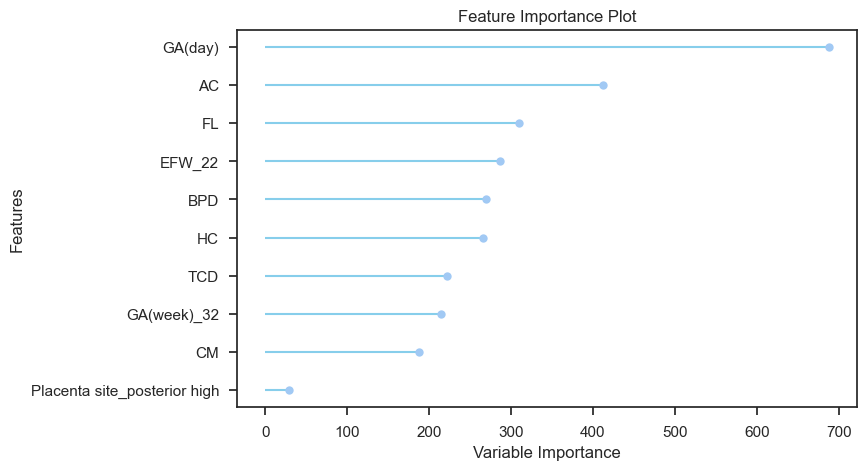

In [69]:
plot_model(model_, 'feature')

## df_32 -> df_35 

In [164]:
df_32_35.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26303 entries, 0 to 26302
Data columns (total 77 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PID                              26303 non-null  int64         
 1   Case number                      26303 non-null  int64         
 2   Exam                             26303 non-null  int64         
 3   Fetus                            26303 non-null  int32         
 4   Hospital no.                     26303 non-null  object        
 5   Ethnic_group                     67 non-null     object        
 6   BPD                              26278 non-null  float64       
 7   HC                               26292 non-null  float64       
 8   TCD                              2534 non-null   float64       
 9   AC                               26301 non-null  float64       
 10  CM                               487 non-null    float64  

In [165]:
df_32_35.shape

(26303, 77)

In [166]:
null_threshold = 400
to_drop = list(df_32_35.loc[:, df_32_35.isnull().sum() > (df_32_35.shape[0] - null_threshold)])
df_32_35_v2 = df_32_35.drop(to_drop, axis=1)
df_32_35_v2 = df_32_35_v2.drop(['PID', 'Case number', 'Exam', 'Fetus', 'EFW centile'], axis=1)

In [167]:
df_32_35_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26303 entries, 0 to 26302
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Hospital no.                    26303 non-null  object        
 1   BPD                             26278 non-null  float64       
 2   HC                              26292 non-null  float64       
 3   TCD                             2534 non-null   float64       
 4   AC                              26301 non-null  float64       
 5   CM                              487 non-null    float64       
 6   FL                              26299 non-null  float64       
 7   Humerus                         1260 non-null   float64       
 8   EFW_32                          26303 non-null  float64       
 9   Fetal heart rate                2209 non-null   float64       
 10  Presentation                    26022 non-null  category      
 11  Pl

In [168]:
#clean up features that has not null > 15k
#BPD, HC, AC, FL, AF Index, Presentation, Placenta site, amniotic fluid, Estimated fetal weight(type)

df_32_35_v2 = df_32_35_v2[   ~df_32_35_v2['BPD'].isnull() & #30488 
                             ~df_32_35_v2['HC'].isnull() & #30506 
                             ~df_32_35_v2['AC'].isnull() & #30517 
                             ~df_32_35_v2['FL'].isnull() & #30515 
                             ~df_32_35_v2['Presentation'].isnull() &#30160 
                             ~df_32_35_v2['Placenta site'].isnull() & #30004 
                             ~df_32_35_v2['Amniotic fluid'].isnull() & #29937 
                             ~df_32_35_v2['EFW Formulae'].isnull() & #30517 
                             ~df_32_35_v2['AF Index'].isnull()#30517 
                            ]

# df_32_35_v2 = df_32_35_v2[df_32_35_v2['Cord'].isin(['3 vessels', 'Single Umbilical Artery', 'abnormal'])]

In [169]:
#clean up features that has not null > 9k
#PI, RI

df_32_35_v3 = df_32_35_v2[   ~df_32_35_v2['PI'].isnull() & #9583
                             ~df_32_35_v2['RI'].isnull() & #9564
                             ~df_32_35_v2['EDF'].isnull()  #12366 
                            ]

In [170]:
#clean up null
null_threshold = 200
to_drop = list(df_32_35_v3.loc[:, df_32_35_v3.isnull().sum() > (df_32_35_v3.shape[0] - null_threshold)])
df_32_35_v4 = df_32_35_v3.drop(to_drop, axis=1)

In [171]:
len(df_32_35_v4['Hospital no.'].unique())

4137

In [172]:
df_32_35_v4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7686 entries, 1 to 23878
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Hospital no.                    7686 non-null   object        
 1   BPD                             7686 non-null   float64       
 2   HC                              7686 non-null   float64       
 3   TCD                             470 non-null    float64       
 4   AC                              7686 non-null   float64       
 5   FL                              7686 non-null   float64       
 6   Humerus                         289 non-null    float64       
 7   EFW_32                          7686 non-null   float64       
 8   Fetal heart rate                583 non-null    float64       
 9   Presentation                    7686 non-null   category      
 10  Placenta site                   7686 non-null   category      
 11  AF 

In [173]:
#cleaning outliers
z_score_list = ['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL','Humerus', 'EFW (clinical)', 'Fetal heart rate', 'GA(day)', 'AF Index',
                'GA(week)', 'PI', 'RI', 'PI (2)', 'RI (2)', 'Cerebro-placental ratio']

for col in df_32_35_v4.columns: #get z_score
    if col in z_score_list:
        col_zscore = col + "_zscore"
        df_32_35_v4[col_zscore] = (df_32_35_v4[col] - df_32_35_v4[col].mean())/df_32_35_v4[col].std(ddof=0) 
        #if 1, then it will divide by n-1, unbiased in samplling (but in our case not sampling so we use ddof=0)
        
rows_to_remove = []
col_to_remove = []
for col in df_32_35_v4:
    if 'zscore' in col:
        col_to_remove.append(col)
        rows_to_remove +=  [i for i in df_32_35_v4[ abs(df_32_35_v4[col]) > 3].index] #filter outliers
        
rows_to_remove = list(set(rows_to_remove))

df_32_35_v4.drop(rows_to_remove, inplace=True) #drop outliers
df_32_35_v4 = df_32_35_v4.loc[:, ~df_32_35_v4.columns.str.endswith('zscore')]

In [174]:
df_32_35_v4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 1 to 23878
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospital no.             7521 non-null   object        
 1   BPD                      7521 non-null   float64       
 2   HC                       7521 non-null   float64       
 3   TCD                      453 non-null    float64       
 4   AC                       7521 non-null   float64       
 5   FL                       7521 non-null   float64       
 6   Humerus                  272 non-null    float64       
 7   EFW_32                   7521 non-null   float64       
 8   Fetal heart rate         560 non-null    float64       
 9   Presentation             7521 non-null   category      
 10  Placenta site            7521 non-null   category      
 11  AF Index                 7521 non-null   float64       
 12  Amniotic fluid           7521 non

In [175]:
len(df_32_35_v4['Hospital no.'].unique())

4087

## I test the features < 4000 non-null to find whether it's worth to keep

- TCD - R2 = -0.03 (Bad)
- Fetal Heart Rate = -0.02 (Bad)
- Cord = -0.01 (Bad)
- PI (2) = 0.0002 (Bad)
- RI (2) = -0.0003 (Bad)
- Cerebro-placental ratio = 0.02 (Bad)
- Humerus - R2 = 0.1516 (Good)
-

In [176]:
df_32_35_v4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 1 to 23878
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospital no.             7521 non-null   object        
 1   BPD                      7521 non-null   float64       
 2   HC                       7521 non-null   float64       
 3   TCD                      453 non-null    float64       
 4   AC                       7521 non-null   float64       
 5   FL                       7521 non-null   float64       
 6   Humerus                  272 non-null    float64       
 7   EFW_32                   7521 non-null   float64       
 8   Fetal heart rate         560 non-null    float64       
 9   Presentation             7521 non-null   category      
 10  Placenta site            7521 non-null   category      
 11  AF Index                 7521 non-null   float64       
 12  Amniotic fluid           7521 non

In [177]:
# col_test = 'Cerebro-placental ratio'
# df_32_35_train = df_32_35_v4[~df_32_35_v4[col_test].isnull() & #30488 
#                              ~df_32_35_v4['EFW_35'].isnull() ] #30506 

df_32_35_train = df_32_35_v4.drop([  'TCD', 'Fetal heart rate', 'Cord', 
                                     'PI (2)', 'RI (2)', 'Cerebro-placental ratio', 
                                     'Humerus'], axis=1)
df_32_35_train = df_32_35_train.drop(['Examination date', 'df_cat'] ,axis=1)
# df_32_35_train = df_32_35_train.drop(['Hospital no.'] ,axis=1)
# df_32_35_train = pd.get_dummies(df_32_35_train, drop_first=True)

## Manual CV

In [178]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_32_35_train['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_32_35_train, df_patient_list, linear_model.BayesianRidge(), 'EFW_35')

,R2,RMSE
0,0.498204,297.425107
1,0.449679,298.415994
2,0.504927,285.194354
3,0.561930,268.361983
4,0.618264,265.126130
5,0.559075,266.420557
6,0.605988,249.545633
7,0.580216,271.398669
8,0.610964,267.408313
9,0.630417,246.381083


In [179]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_32_35_train['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

In [180]:
df_32_35_pycaret = df_32_35_train.loc[df_32_35_train['Hospital no.'].isin(train_patient), :]
df_32_35_test = df_32_35_train.loc[df_32_35_train['Hospital no.'].isin(test_patient), :]

df_32_35_pycaret.drop('Hospital no.', axis=1, inplace=True)
df_32_35_test.drop('Hospital no.', axis=1, inplace=True)

In [86]:
# df_32_35_pycaret.shape

In [87]:
# len(df_32_35_pycaret['Hospital no.'].unique())

In [ ]:
# len(df_train_22_32_pycaret['Hospital no.'].unique())

In [222]:
# check_df(df_32_35_pycaret)

No null exist in this dataframe.


In [225]:
exp_reg101 = setup(data = df_32_35_pycaret, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(6892, 17)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4824, 51)"


In [226]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,215.4473,76461.3932,276.4050,0.5502,0.1006,0.0791,0.0150
lasso,Lasso Regression,215.5353,76548.2164,276.5586,0.5496,0.1007,0.0791,0.0140
ridge,Ridge Regression,216.1378,76818.4570,277.0602,0.5480,0.1008,0.0793,0.0080
lr,Linear Regression,216.5361,77015.3586,277.4192,0.5468,0.1010,0.0795,0.4390
gbr,Gradient Boosting Regressor,217.0769,77330.4174,277.9865,0.5447,0.1010,0.0798,0.2970
omp,Orthogonal Matching Pursuit,218.2894,78141.6489,279.4384,0.5402,0.1017,0.0801,0.0100
lightgbm,Light Gradient Boosting Machine,221.2520,79642.1139,282.1174,0.5308,0.1025,0.0812,0.1520
en,Elastic Net,221.3599,79850.9289,282.4567,0.5304,0.1031,0.0816,0.0170
huber,Huber Regressor,221.5390,82271.7250,286.6580,0.5163,0.1045,0.0810,0.1480
rf,Random Forest Regressor,228.8082,84166.8865,290.0114,0.5042,0.1054,0.0841,0.7220


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [228]:
model_ = create_model('br')
predicted = predict_model(model_, df_32_35_test)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,207.3591,71528.7079,267.4485,0.5659,0.0998,0.0774
1,216.6009,76336.8317,276.2912,0.5373,0.1005,0.0802
2,214.1298,74678.4270,273.2735,0.5230,0.0993,0.0784
3,214.1995,76655.8442,276.8679,0.5413,0.1008,0.0788
4,211.4660,76076.1137,275.8190,0.5768,0.1002,0.0774
5,216.6624,78046.9633,279.3689,0.5677,0.1007,0.0792
6,228.7213,86276.6728,293.7289,0.5733,0.1048,0.0822
7,209.9078,69647.9588,263.9090,0.5579,0.0976,0.0785
8,211.0044,74877.4543,273.6375,0.5471,0.0986,0.0762
9,224.4218,80488.9587,283.7058,0.5115,0.1036,0.0826


In [229]:
y_true = predicted['EFW_35']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [230]:
r2, rmse

(0.6314280748662853, 246.04391926443074)

In [235]:
df_32_35_train.shape

(7521, 18)

In [72]:
len(df_32_35_train['EFW_35'].unique())

1661

In [73]:
exp_reg101 = setup(data = df_32_35_train, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(7521, 18)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5264, 3328)"


In [ ]:
compare_models()

In [ ]:
model_ = create_model('lasso')

In [ ]:
plot_model(model_, 'feature')

## Merge 22+32 with 35 to see

In [181]:
df_22_32_v3

,Hospital no.,BPD,HC,TCD,AC,CM,FL,Humerus,EFW_22,Fetal heart rate,Presentation,Placenta site,Amniotic fluid,Cord,EFW Formulae,Examination date,GA(day),GA(week),df_cat,GA(week)_32,EFW_32
0,31146923,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,cephalic,posterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2012-10-11,149.0,21.0,wk22,30.0,1273.0
1,12350378,51.2,190.7,22.1,163.8,6.0,34.8,NaN,410.0,NaN,Extended breech,posterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2012-10-11,142.0,20.0,wk22,29.0,1459.0
2,12350378,51.2,190.7,22.1,163.8,6.0,34.8,NaN,410.0,NaN,Extended breech,posterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2012-10-11,142.0,20.0,wk22,33.0,2200.0
3,31120474,61.0,222.6,28.3,202.5,4.8,43.7,NaN,716.0,NaN,cephalic,anterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2012-10-12,174.0,24.0,wk22,34.0,2292.0
4,23207809,56.9,214.3,26.7,208.5,4.0,44.2,NaN,735.0,NaN,cephalic,posterior left,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2012-10-12,172.0,24.0,wk22,34.0,2229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28422,35951331,51.2,187.2,22.6,179.4,6.7,34.7,NaN,457.0,NaN,breech,posterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2021-01-13,148.0,21.0,wk22,30.0,1749.0
28423,31775708,55.7,217.0,25.9,204.3,6.2,41.8,NaN,679.0,NaN,transverse,posterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2021-01-14,174.0,24.0,wk22,34.0,2370.0
28424,32435207,57.3,201.7,25.9,185.7,5.5,45.4,NaN,639.0,NaN,cephalic,anterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2021-01-14,167.0,23.0,wk22,28.0,1088.0
28425,32435207,57.3,201.7,25.9,185.7,5.5,45.4,NaN,639.0,NaN,cephalic,anterior high,normal,3 vessels,Hadlock (BPD-HC-AC-FL),2021-01-14,167.0,23.0,wk22,34.0,2152.0


In [182]:
df_22_32_v3_tomerge = df_22_32_v3.copy()
df_22_32_v3_tomerge.drop(['Presentation', 'Placenta site', 'Cord', 'EFW Formulae', 
                          'Examination date', 'df_cat', 'GA(week)_32', 'EFW_32'], axis=1, inplace=True)
df_22_32_v3_tomerge = df_22_32_v3_tomerge.rename(columns={'EFW (clinical)': 'EFW'})

for col in df_22_32_v3_tomerge.columns:
    if col == 'Hospital no.' or col == 'EFW_22':
        continue
    df_22_32_v3_tomerge = df_22_32_v3_tomerge.rename(columns={col:col+'_22'})

In [183]:
df_22_32_v3_tomerge.columns

Index(['Hospital no.', 'BPD_22', 'HC_22', 'TCD_22', 'AC_22', 'CM_22', 'FL_22',
       'Humerus_22', 'EFW_22', 'Fetal heart rate_22', 'Amniotic fluid_22',
       'GA(day)_22', 'GA(week)_22'],
      dtype='object')

In [189]:
#remove humerus because later will left only 400+ rows
df_32_35_merge = df_32_35_v4.drop([  'TCD', 'Fetal heart rate', 'Cord', 
                                     'PI (2)', 'RI (2)', 'Cerebro-placental ratio', 
                                     'Humerus', 'Examination date', 'df_cat'], axis=1) 


In [190]:
#merge here
df_22_32_35 = pd.merge(df_22_32_v3_tomerge, df_32_35_merge, on='Hospital no.', how='inner')

In [191]:
df_22_32_v3_tomerge.columns

Index(['Hospital no.', 'BPD_22', 'HC_22', 'TCD_22', 'AC_22', 'CM_22', 'FL_22',
       'Humerus_22', 'EFW_22', 'Fetal heart rate_22', 'Amniotic fluid_22',
       'GA(day)_22', 'GA(week)_22'],
      dtype='object')

In [192]:
df_22_32_35.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18194 entries, 0 to 18193
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Hospital no.         18194 non-null  object  
 1   BPD_22               18194 non-null  float64 
 2   HC_22                18194 non-null  float64 
 3   TCD_22               18194 non-null  float64 
 4   AC_22                18194 non-null  float64 
 5   CM_22                18194 non-null  float64 
 6   FL_22                18194 non-null  float64 
 7   Humerus_22           9983 non-null   float64 
 8   EFW_22               18194 non-null  float64 
 9   Fetal heart rate_22  2499 non-null   float64 
 10  Amniotic fluid_22    18194 non-null  category
 11  GA(day)_22           18194 non-null  float64 
 12  GA(week)_22          18194 non-null  float64 
 13  BPD                  18194 non-null  float64 
 14  HC                   18194 non-null  float64 
 15  AC                 

In [196]:
df_22_32_35_train = df_22_32_35[~df_22_32_35['Humerus_22'].isnull()]
df_22_32_35_train = df_22_32_35_train.drop('Fetal heart rate_22', axis=1)
exp_reg101 = setup(data = df_22_32_35_train, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(9983, 29)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6988, 62)"


In [195]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,78.5774,25460.6889,159.3324,0.8410,0.0573,0.0286,0.8640
rf,Random Forest Regressor,103.9869,28144.2605,167.5731,0.8243,0.0605,0.0381,1.2700
dt,Decision Tree Regressor,92.7849,38773.3401,196.6872,0.7580,0.0707,0.0338,0.0530
lightgbm,Light Gradient Boosting Machine,149.8288,39608.4664,198.8554,0.7527,0.0723,0.0553,0.1000
gbr,Gradient Boosting Regressor,198.4578,62869.3466,250.6434,0.6078,0.0920,0.0739,0.5700
knn,K Neighbors Regressor,196.5699,74478.2941,272.6200,0.5357,0.0988,0.0724,0.0510
ridge,Ridge Regression,221.2360,78115.3773,279.4236,0.5126,0.1030,0.0824,0.0280
br,Bayesian Ridge,221.6362,78230.8357,279.6279,0.5119,0.1031,0.0826,0.0510
lasso,Lasso Regression,222.8467,78874.1227,280.7824,0.5079,0.1035,0.0830,0.0620
lr,Linear Regression,224.9832,80668.4117,283.9551,0.4966,0.1047,0.0839,0.6480


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=12, verbose=0, warm_start=False)

In [ ]:
model_ = create_model('et')

In [ ]:
plot_model(model_, 'feature')

In [241]:
df_22_32_35.columns

Index(['Hospital no.', 'BPD_22', 'HC_22', 'TCD_22', 'AC_22', 'CM_22', 'FL_22',
       'Humerus_22', 'EFW_22_22', 'Fetal heart rate_22', 'Amniotic fluid_22',
       'GA(day)_22', 'GA(week)_22', 'BPD', 'HC', 'AC', 'FL', 'EFW_22',
       'Presentation', 'Placenta site', 'AF Index', 'Amniotic fluid', 'PI',
       'RI', 'EDF', 'EFW Formulae', 'GA(day)', 'GA(week)', 'GA(week)_35',
       'EFW_35'],
      dtype='object')

In [243]:
# df_22_32_35.shape
# len(df_22_32_35['Hospital no.'].unique())

# check_df(df_22_32_35)
#Humerus_22 has 0.1825 r2 to EFW_35
#Fetal heart rate_22 has 0.07 r2 to EFW_35

#so let's try 2: With humerus and without humerus

Humerus_22: null=8211, dtypes=float64
Fetal heart rate_22: null=15695, dtypes=float64


## Manual CV

In [203]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#with humerus
# df_22_32_35_train = df_22_32_35[~df_22_32_35['Humerus_22'].isnull()]
# df_22_32_35_train = df_22_32_35_train.drop('Fetal heart rate_22', axis=1)
df_22_32_35_train = df_22_32_35.drop(['Fetal heart rate_22', 'Humerus_22'], axis=1)

patient_list = list(df_22_32_35_train['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

df_22_32_35_pycaret = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(train_patient), :]
df_22_32_35_test = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(test_patient), :]

df_22_32_35_pycaret.drop('Hospital no.', axis=1, inplace=True)
df_22_32_35_test.drop('Hospital no.', axis=1, inplace=True)

# df_22_32_35_train = df_22_32_35.drop(['Hospital no.'], axis=1)
# df_22_32_35_train = pd.get_dummies(df_22_32_35_train, drop_first=True)

In [204]:
check_df(df_22_32_35_train)

No null exist in this dataframe.


In [205]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor

patient_list = list(df_22_32_35_train['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_32_35_train, df_patient_list, ExtraTreesRegressor(), 'EFW_35')

,R2,RMSE
0,0.416865,318.914917
1,0.312196,302.801990
2,0.462856,300.833595
3,0.462047,301.491730
4,0.460699,291.789534
5,0.419065,305.747425
6,0.421222,289.363191
7,0.507049,282.315704
8,0.468681,297.653476
9,0.549036,264.405153


In [265]:
# df_22_32_35_test.shape

(601, 28)

In [266]:
# len(df_22_32_35_test['Hospital no.'].unique())

KeyError: 'Hospital no.'

In [267]:
exp_reg101 = setup(data = df_22_32_35_pycaret, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(9382, 28)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6567, 57)"


In [268]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,80.7185,27193.1500,164.7427,0.8276,0.0593,0.0295,0.7790
rf,Random Forest Regressor,105.3997,29647.2099,172.0705,0.8120,0.0622,0.0388,1.1680
xgboost,Extreme Gradient Boosting,120.5801,32020.8266,178.8412,0.7970,0.0647,0.0444,0.6380
lightgbm,Light Gradient Boosting Machine,148.0382,38928.7820,197.2580,0.7534,0.0717,0.0547,0.1820
dt,Decision Tree Regressor,94.2368,40244.6761,200.0651,0.7459,0.0723,0.0344,0.0320
gbr,Gradient Boosting Regressor,198.4241,63070.2175,251.0934,0.6005,0.0922,0.0737,0.4930
ridge,Ridge Regression,221.9865,78610.0062,280.3316,0.5020,0.1034,0.0827,0.0120
lr,Linear Regression,221.8769,78637.2867,280.3794,0.5019,0.1034,0.0827,0.4830
br,Bayesian Ridge,222.4704,78749.2627,280.5830,0.5012,0.1035,0.0829,0.0230
lasso,Lasso Regression,223.3928,79254.4258,281.4862,0.4979,0.1038,0.0833,0.0340


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=12, verbose=0, warm_start=False)

In [269]:
model_ = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,80.8349,25829.7435,160.7163,0.8282,0.0581,0.0300
1,85.1359,29447.6745,171.6032,0.8111,0.0617,0.0307
2,78.0909,25993.6858,161.2256,0.8261,0.0573,0.0280
3,85.9271,32117.0499,179.2123,0.7923,0.0644,0.0316
4,79.5895,26013.8788,161.2882,0.8270,0.0586,0.0294
5,80.5913,29397.2045,171.4561,0.8216,0.0620,0.0298
6,75.8813,23320.8572,152.7117,0.8532,0.0554,0.0275
7,84.7207,27999.4880,167.3305,0.8260,0.0603,0.0309
8,76.9887,26527.6213,162.8730,0.8403,0.0588,0.0283
9,79.4247,25284.2965,159.0104,0.8503,0.0567,0.0292


KeyError: "['BPD_22', 'HC_22', 'TCD_22', 'AC_22', 'CM_22', 'FL_22', 'Humerus_22', 'EFW_22_22', 'Amniotic fluid_22', 'GA(day)_22', 'GA(week)_22'] not in index"

In [270]:
#write custom code to cross validate this!

predicted = predict_model(model_, df_22_32_35_test)

In [271]:
y_true = predicted['EFW_35']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [272]:
r2, rmse

(0.4621341166186227, 310.8438931356762)

In [284]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#without humerus
df_22_32_35_train = df_22_32_35.copy()
df_22_32_35_train.drop(['Humerus_22','Fetal heart rate_22'], axis=1, inplace=True)

patient_list = list(df_22_32_35_train['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

df_22_32_35_pycaret = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(train_patient), :]
df_22_32_35_test = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(test_patient), :]

df_22_32_35_pycaret.drop('Hospital no.', axis=1, inplace=True)
df_22_32_35_test.drop('Hospital no.', axis=1, inplace=True)

# df_22_32_35_train = df_22_32_35.drop(['Hospital no.'], axis=1)
# df_22_32_35_train = pd.get_dummies(df_22_32_35_train, drop_first=True)

In [281]:
df_22_32_35_pycaret.shape

(17185, 28)

In [282]:
len(df_22_32_35_pycaret['Hospital no.'].unique())

2001

In [285]:
exp_reg101 = setup(data = df_22_32_35_pycaret, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(17185, 27)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12029, 62)"


In [286]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,76.9989,24491.8790,156.3510,0.8416,0.0564,0.0281,1.6130
rf,Random Forest Regressor,98.8611,26715.7646,163.3646,0.8272,0.0590,0.0363,2.4120
xgboost,Extreme Gradient Boosting,134.5166,34846.9758,186.5709,0.7746,0.0680,0.0496,1.0570
dt,Decision Tree Regressor,89.5325,36040.4981,189.6065,0.7667,0.0682,0.0327,0.0570
lightgbm,Light Gradient Boosting Machine,163.1469,45297.5917,212.7870,0.7070,0.0780,0.0605,0.2200
gbr,Gradient Boosting Regressor,206.5622,67435.8845,259.6370,0.5640,0.0957,0.0770,0.9690
ridge,Ridge Regression,223.5618,79691.9664,282.2662,0.4846,0.1043,0.0835,0.0170
lr,Linear Regression,223.5269,79704.0812,282.2876,0.4845,0.1043,0.0835,0.4200
br,Bayesian Ridge,223.7729,79802.9164,282.4629,0.4839,0.1044,0.0836,0.0670
knn,K Neighbors Regressor,215.5814,80455.3734,283.5354,0.4799,0.1034,0.0796,0.0780


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=12, verbose=0, warm_start=False)

In [287]:
model_ = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,74.2353,22768.4119,150.8921,0.8525,0.0548,0.0273
1,72.6012,21737.6661,147.4370,0.8654,0.0532,0.0263
2,81.5235,27740.4404,166.5546,0.8197,0.0600,0.0296
3,74.4282,22816.4565,151.0512,0.8497,0.0549,0.0274
4,78.6981,26008.6037,161.2718,0.8342,0.0580,0.0286
5,73.6414,22274.8029,149.2475,0.8408,0.0538,0.0272
6,81.6072,26658.7854,163.2752,0.8300,0.0594,0.0302
7,81.6541,27032.2309,164.4148,0.8315,0.0590,0.0297
8,76.0121,25093.3552,158.4088,0.8377,0.0569,0.0277
9,75.5877,22788.0370,150.9571,0.8552,0.0538,0.0270


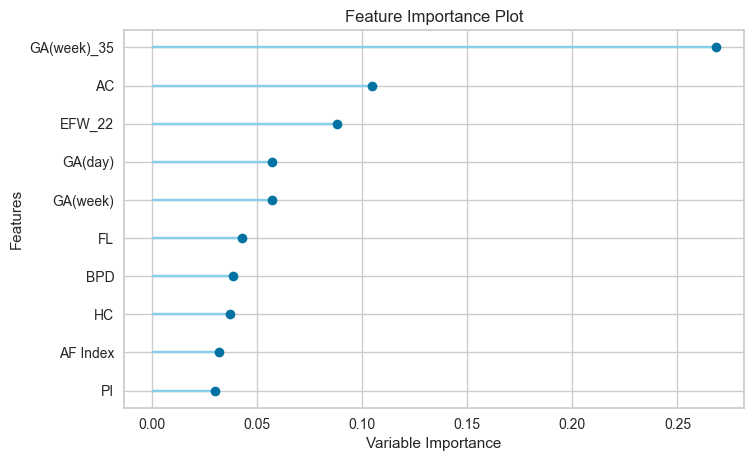

In [291]:
plot_model(model_, 'feature')

In [288]:
predicted = predict_model(model_, df_22_32_35_test)

In [289]:
y_true = predicted['EFW_35']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [290]:
r2, rmse

(0.5169381377261013, 280.3690418814487)

# tmr:
1. Handle outliers!

In [ ]:
df_master[df_master['GA(day)']==0]

In [ ]:
df_master['Fetus'].value_counts()

In [ ]:
df_master[~df_master['MCA RI (2)'].isnull()]

# Planning
 
1. Split into 3df, try to identify usable data (here means identify patient that has 3 records of different wk) regardless of missing value first
- Visualize each wk
- Check feature relationships 
- Handling missing value
- Feature Engineer some stuff if possible
- Try pycaret

19/11/2021
- Summarize those stuff